### This project is a study for research and develop methods with references from
### https://github.com/Samimust/predictive-maintenance
remaining cycles before failure (TTF)
label bnc : 0 = not broken , 1 = broken

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
# from itertools import cycle
from sklearn import metrics
from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,roc_auc_score

import xgboost as xgb
from vecstack import stacking

In [6]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [7]:
df_train.drop('id',axis=1,inplace=True)
df_test.drop('id',axis=1,inplace=True)

In [8]:
df_test.head(6)

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,21.61,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,21.61,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0
5,105,0.0076,-0.0003,100.0,518.67,643.05,1586.94,1404.49,14.62,21.61,...,0.007488,0.0,0.447214,0.0,0.0,0.153395,0.071794,93,0,0


In [9]:
df_train.isnull().any().sum()

0

In [10]:
print(df_train.shape , df_test.shape)

(20631, 70) (100, 70)


## EDA

In [11]:
list(set(df_train.dtypes.tolist()))

[dtype('float64'), dtype('int64')]

In [16]:
# df_cat = df_train.select_dtypes(include=['object']).copy()
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num.head(2)

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,191,0,0
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,0.008697,0.0,0.0,0.0,0.0,0.042426,0.003253,190,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F34B959A58>,
      dtype=object)

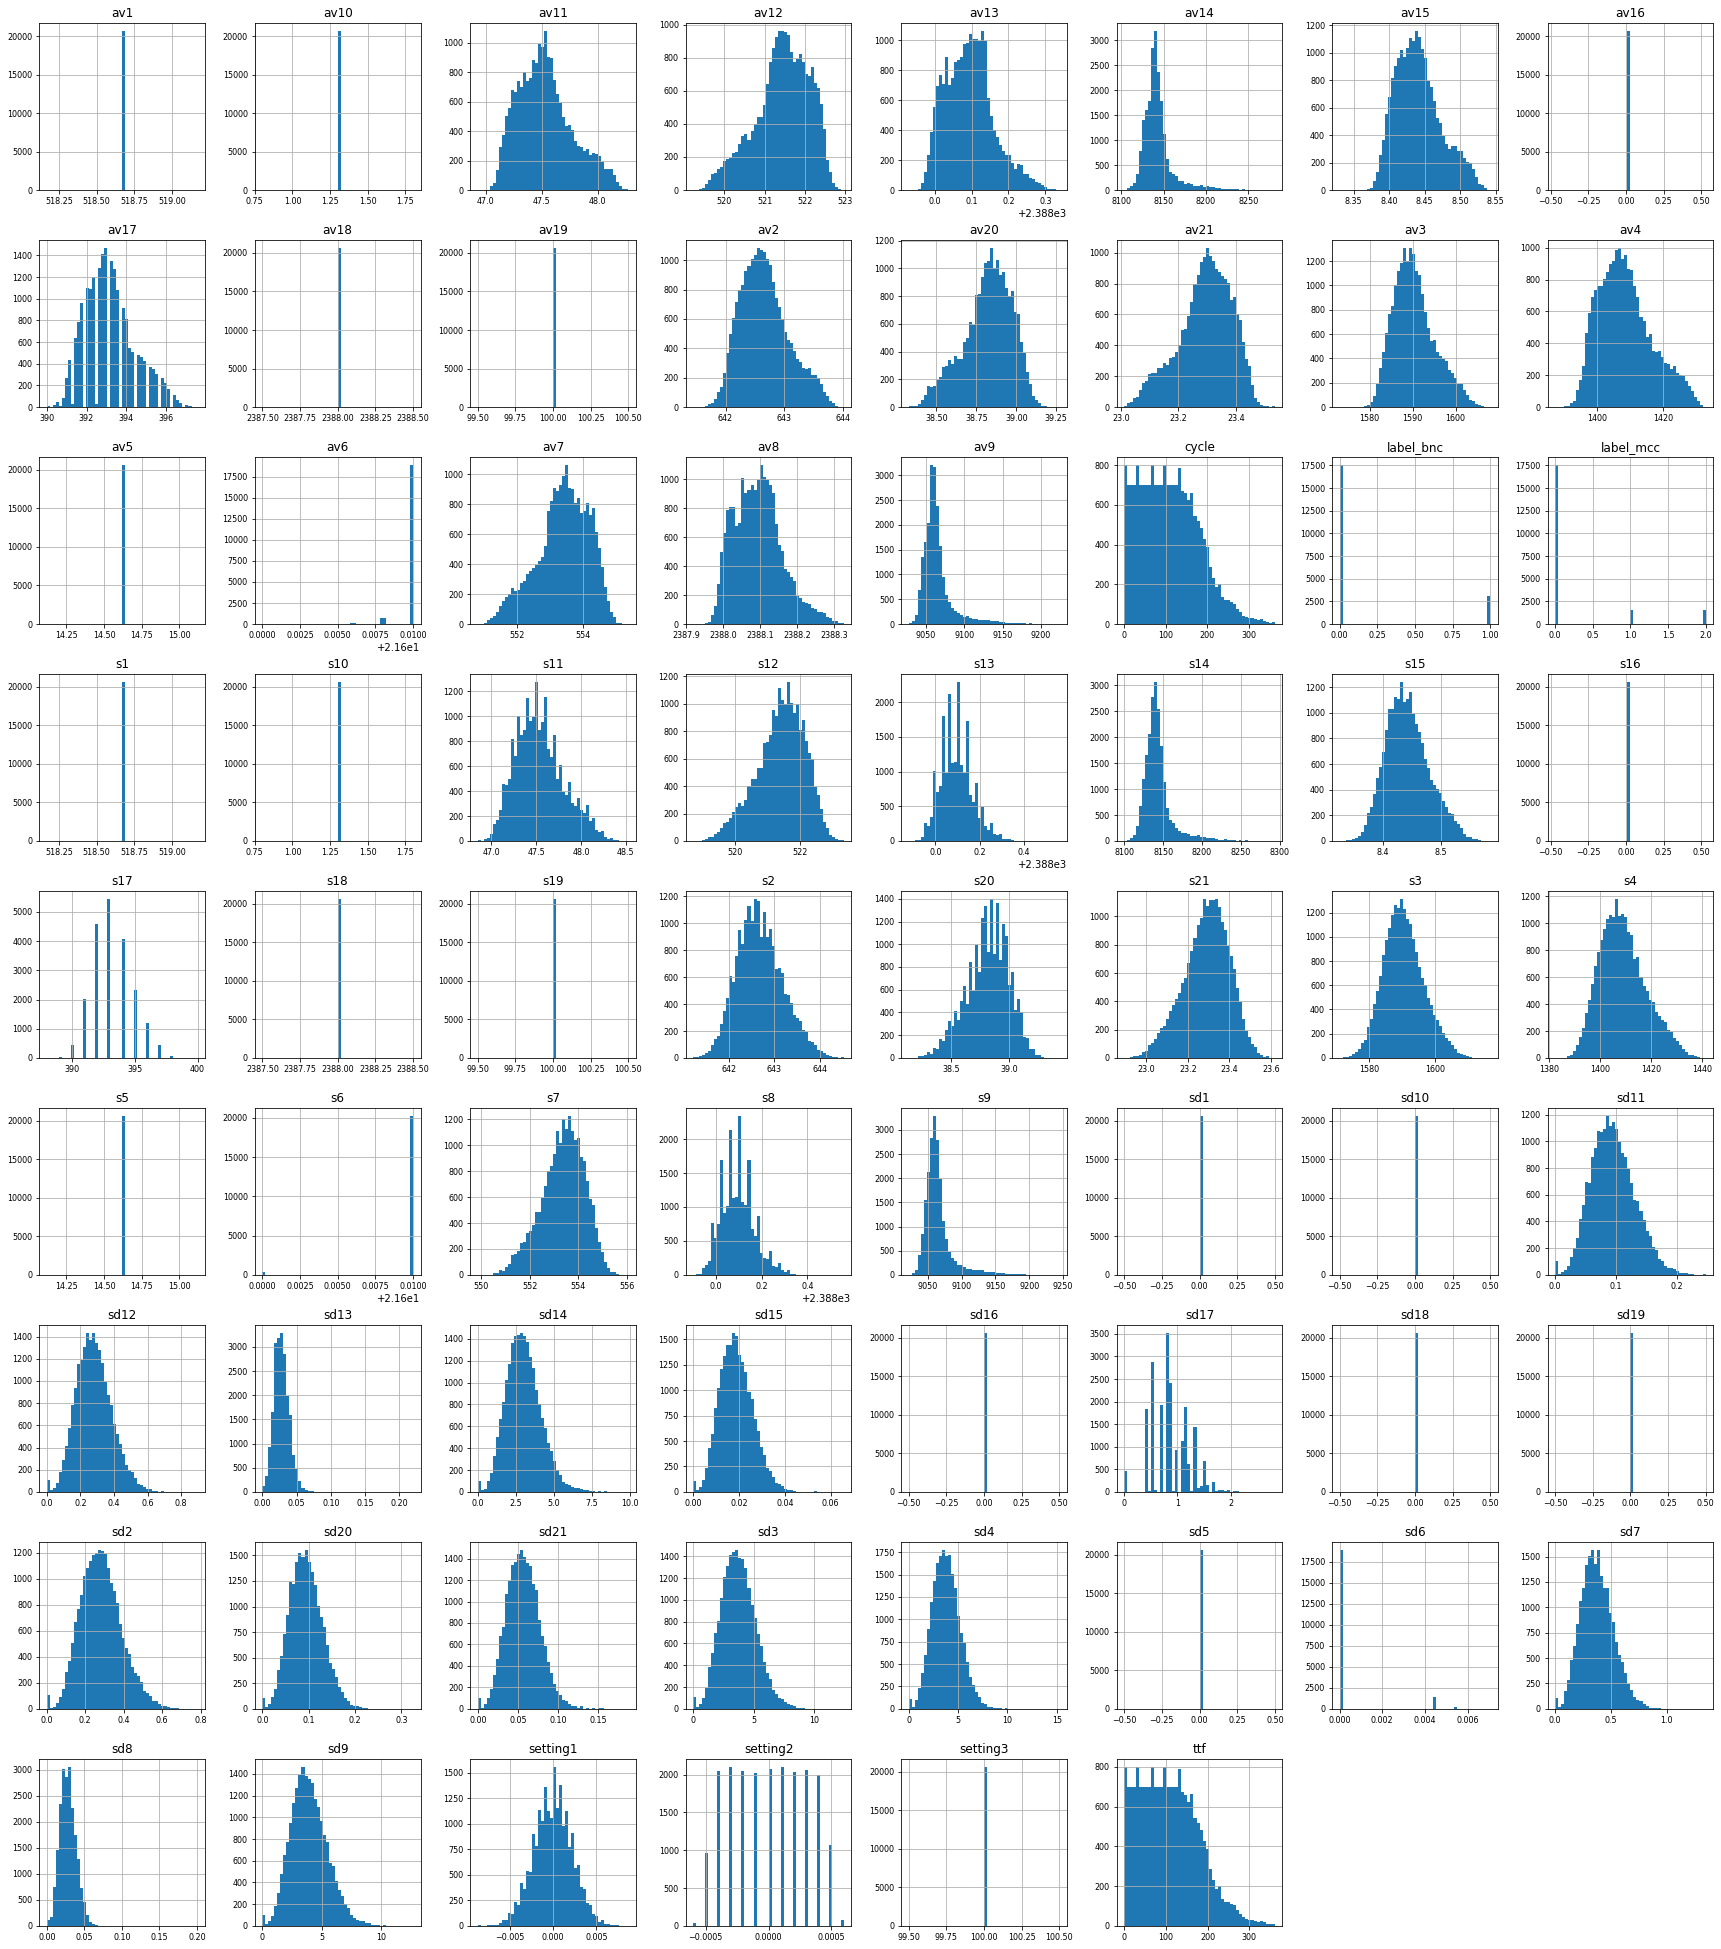

In [9]:
df_num.hist(figsize=(30, 35), bins=50, xlabelsize=8, ylabelsize=8)

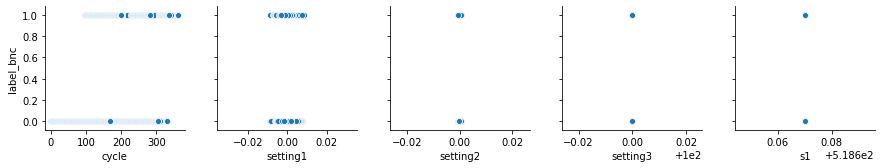

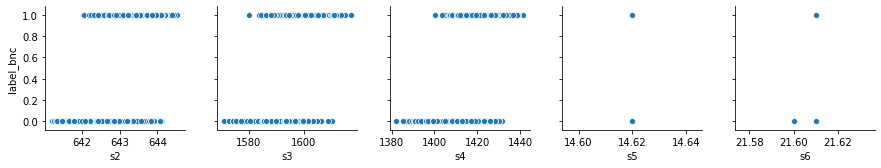

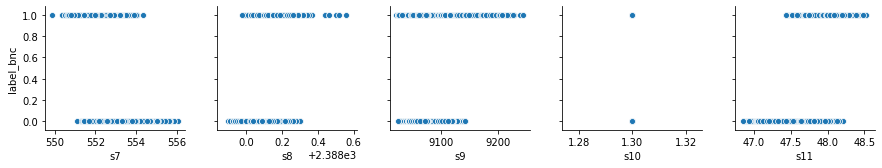

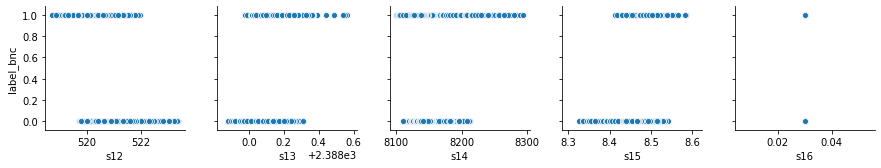

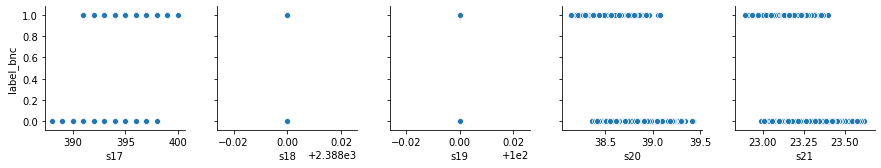

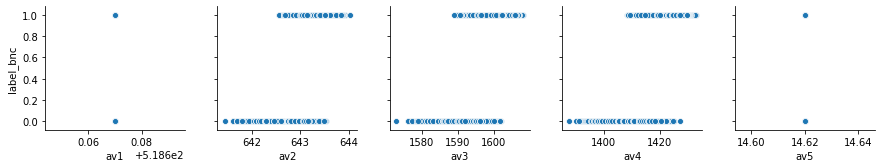

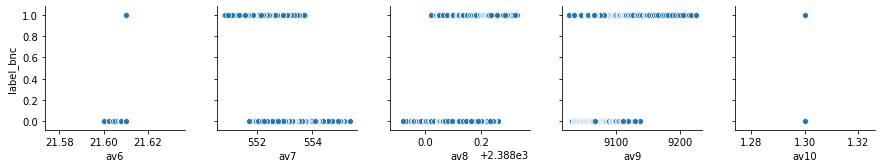

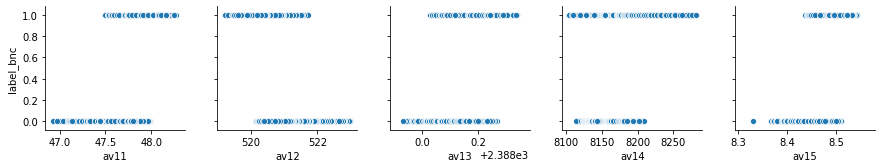

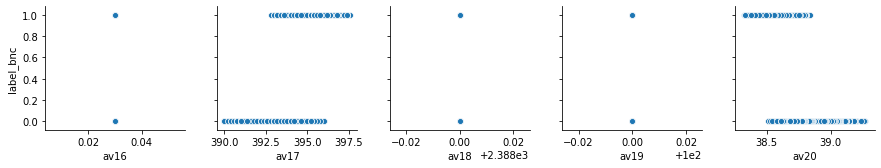

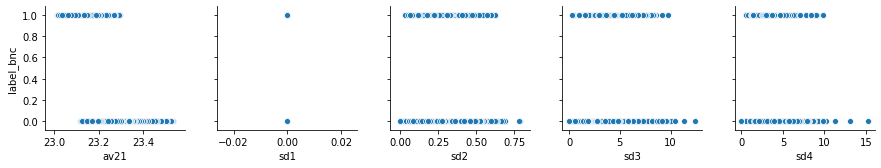

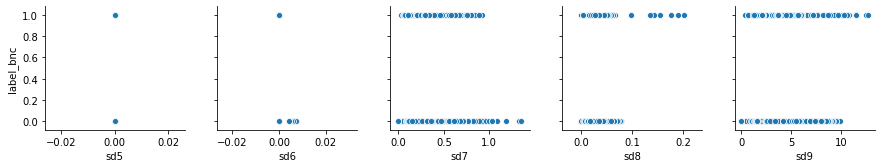

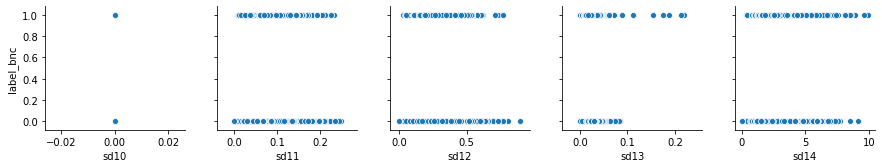

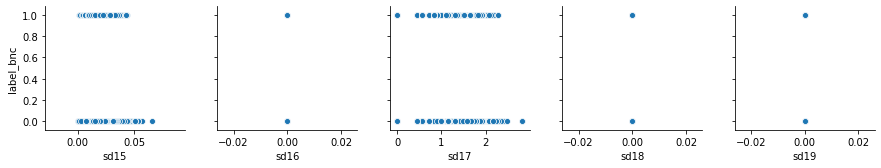

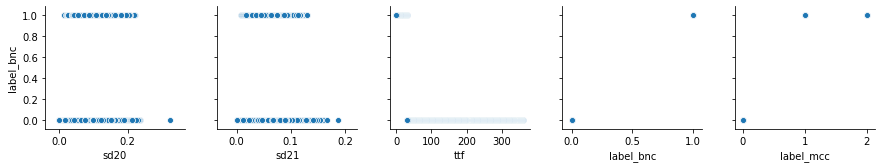

In [180]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['label_bnc'])

In [17]:
## sensor ไหนที่มีค่าเดียวหมดเลยทั้งcolumn dropไป
cc=[]
for i in range(1,22):
    if df_num["s"+str(i)].sum() == df_num["av"+str(i)].sum():
        cc.append('s'+str(i))
cc

['s1', 's5', 's10', 's16', 's18', 's19']

In [18]:
df_num.drop(['s1', 's5', 's10', 's16', 's18', 's19'],axis=1,inplace=True)

In [19]:
df_num.head(2)

,cycle,setting1,setting2,setting3,s2,s3,s4,s6,s7,s8,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,191,0,0
1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,0.008697,0.0,0.0,0.0,0.0,0.042426,0.003253,190,0,0


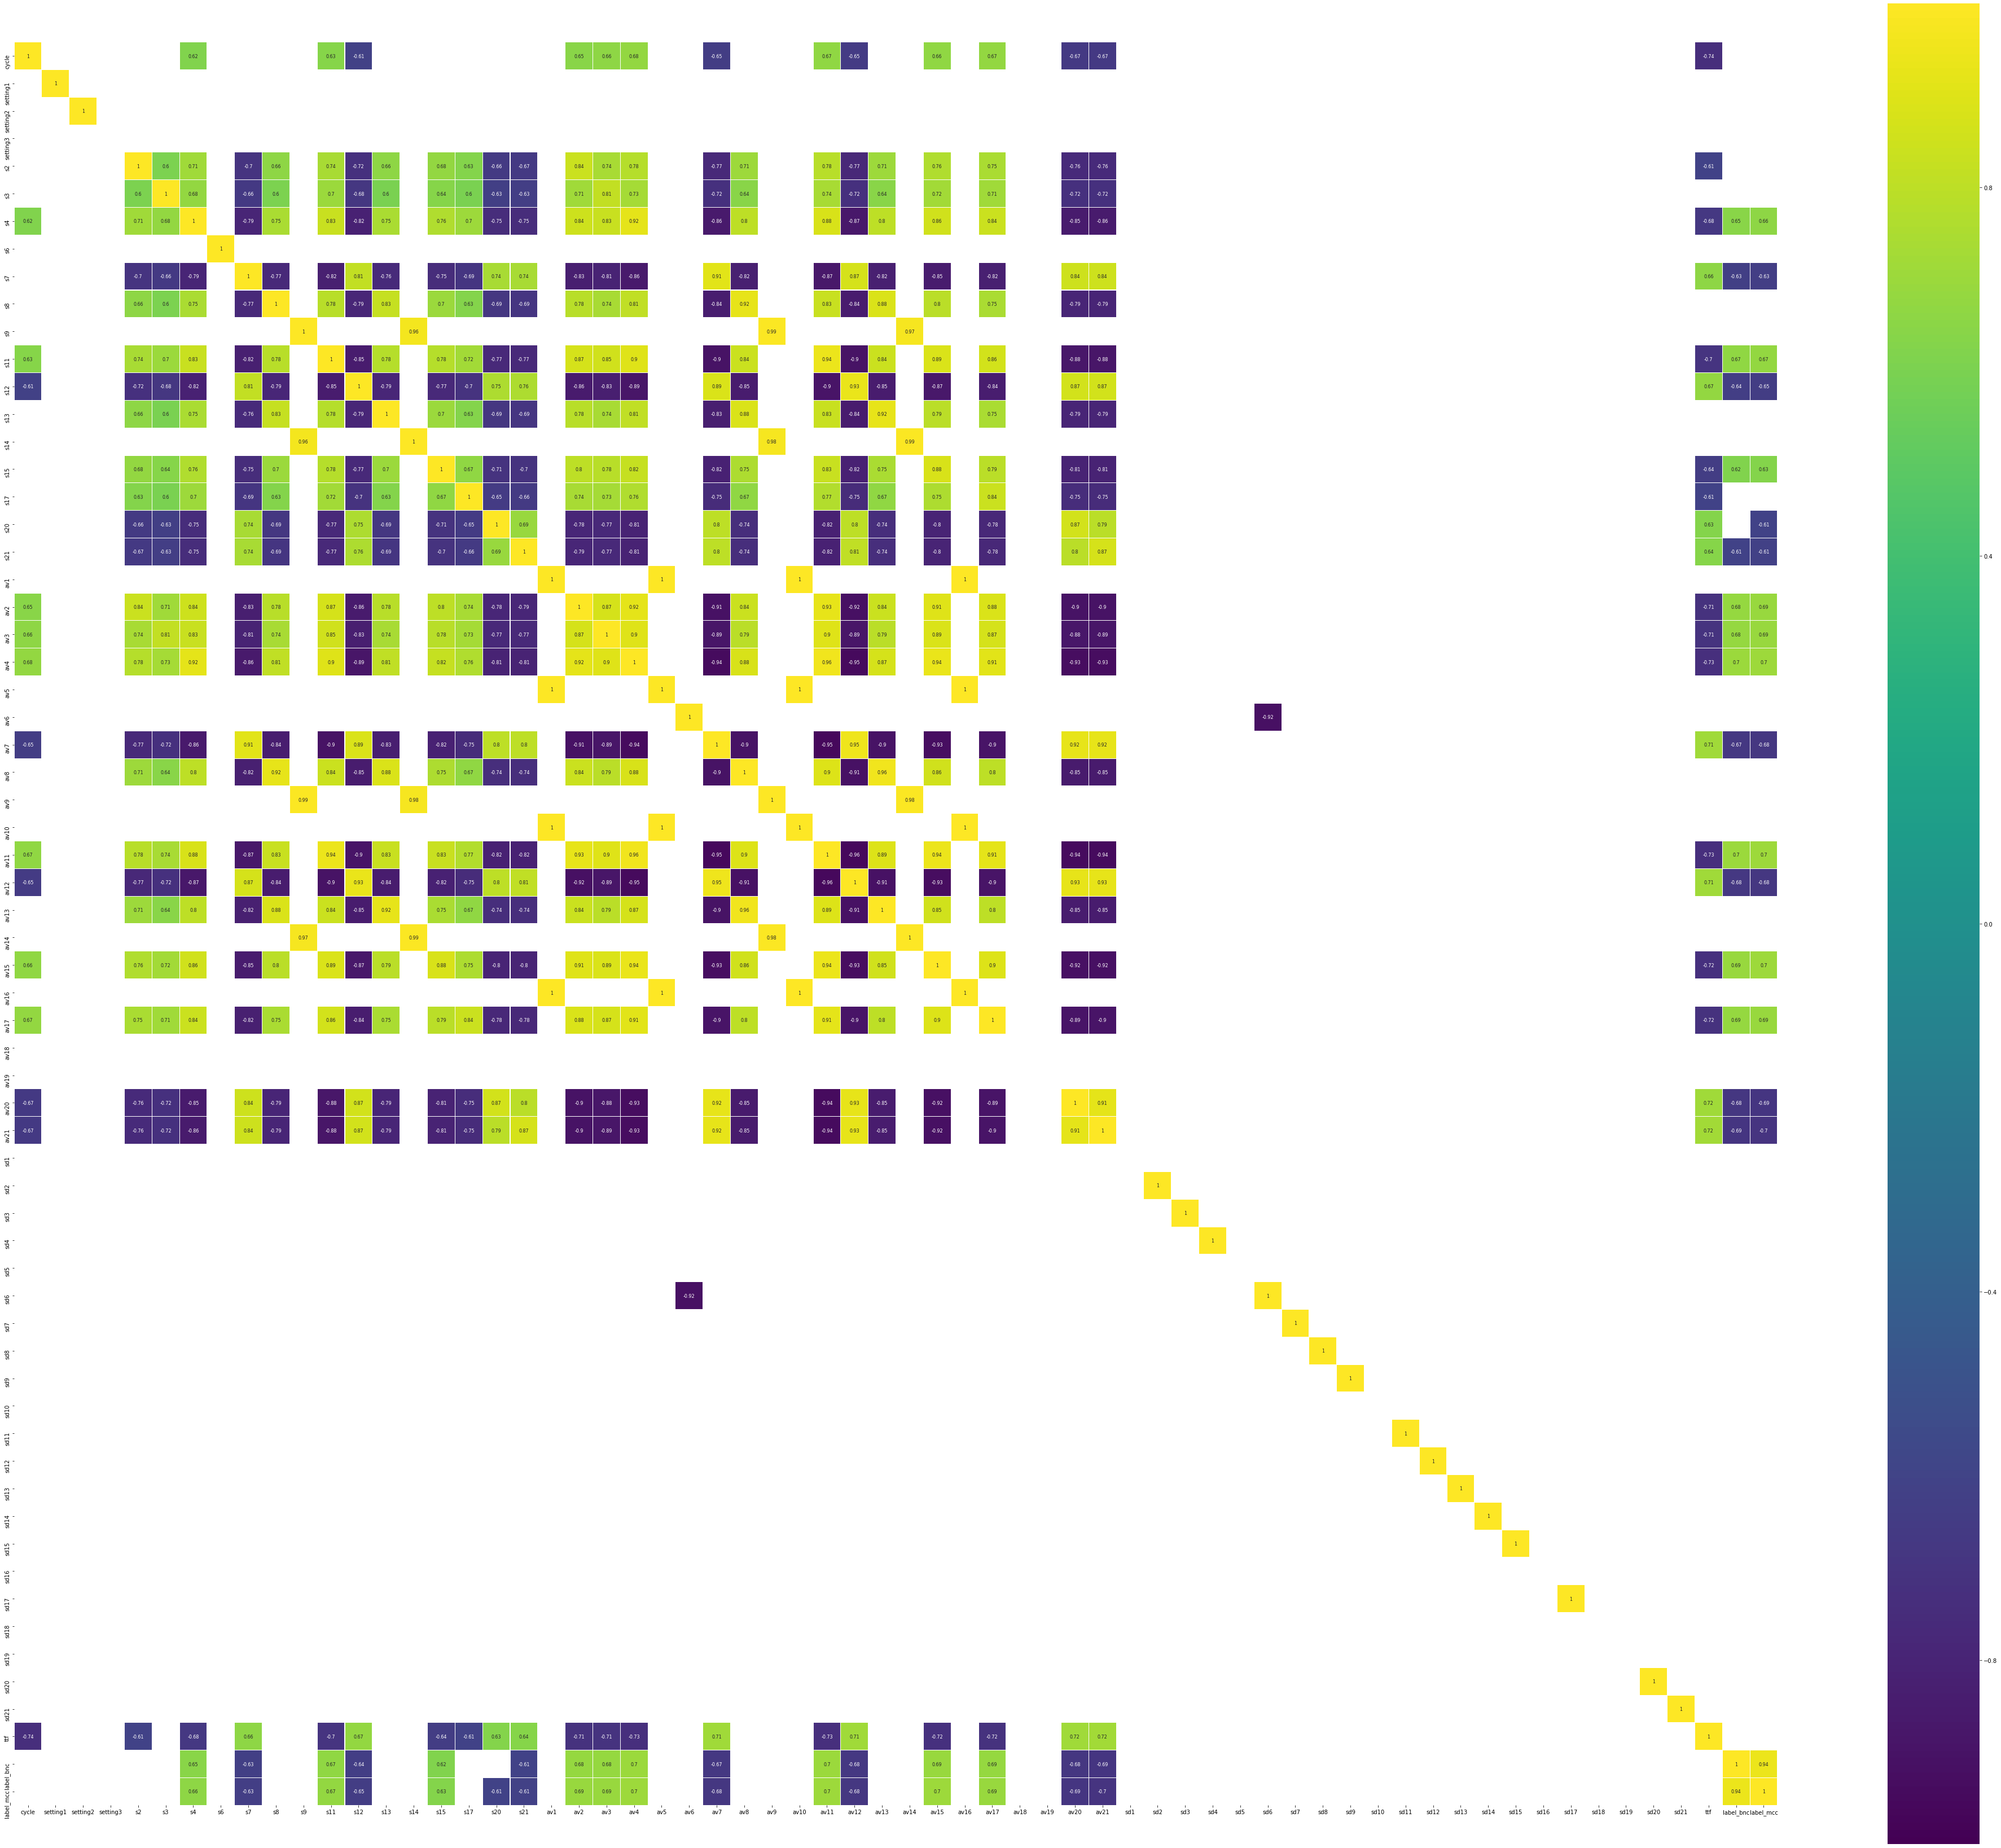

In [305]:
#corr = df.drop('gender', axis=1).corr() # We already examined SalePrice correlations
corr=df_num.corr()
plt.figure(figsize=(70,60))

sns.heatmap(corr[(corr >= 0.6) | (corr <= -0.6)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [66]:
df_num_corr = df_num.corr()['label_bnc'][:-2]  
features_list = df_num_corr[abs(df_num_corr) > 0.6].sort_values(ascending=False)
print("There is {} strongly correlated values with label_bnc:\n{}".format(len(features_list),features_list))

There is 16 strongly correlated values with label_bnc:
av11    0.696717
av4     0.695622
av15    0.693216
av17    0.685537
av3     0.681233
av2     0.680308
s11     0.665655
s4      0.648406
s15     0.618732
s21    -0.606480
s7     -0.625592
s12    -0.640174
av7    -0.674600
av12   -0.677270
av20   -0.681137
av21   -0.687582
Name: label_bnc, dtype: float64


In [67]:
import operator

In [68]:
features_list = sorted(features_list.items(), key=operator.itemgetter(1))
features=[]
for (key, value) in features_list:
    features.append(key)

In [69]:
features
print(features,len(features))

['av21', 'av20', 'av12', 'av7', 's12', 's7', 's21', 's15', 's4', 's11', 'av2', 'av3', 'av17', 'av15', 'av4', 'av11'] 16


### high correlate with ttf
### 'av21', 'av20', 'av12', 'av7', 's12', 's7', 's21', 's15', 's4', 's11', 'av2', 'av3', 'av17', 'av15', 'av4', 'av11'

## Imbalance Data

C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

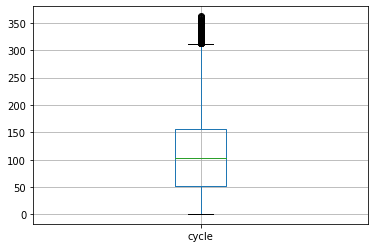

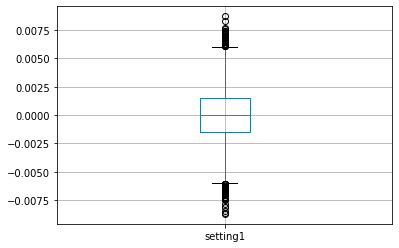

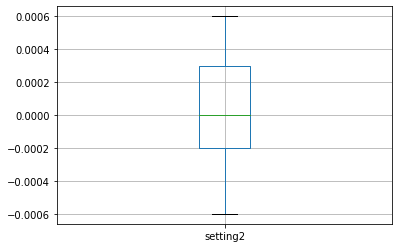

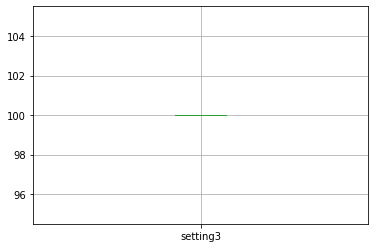

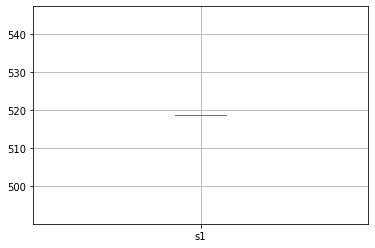

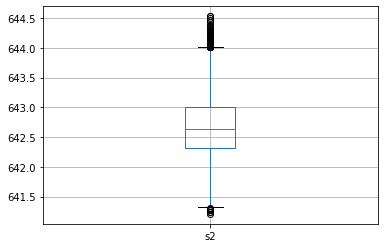

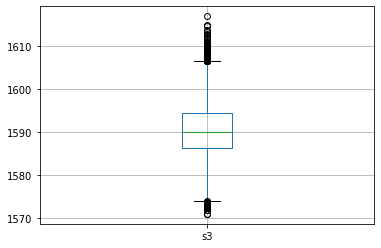

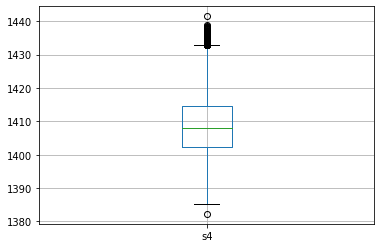

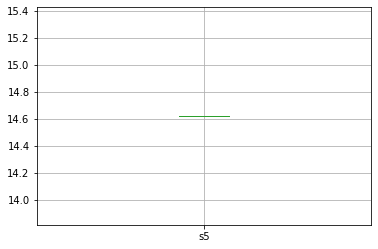

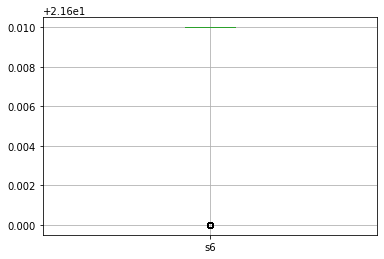

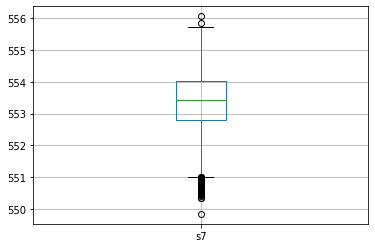

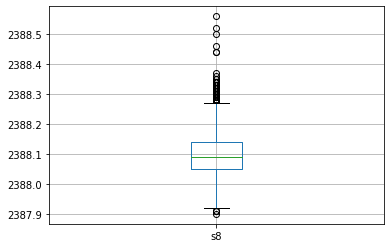

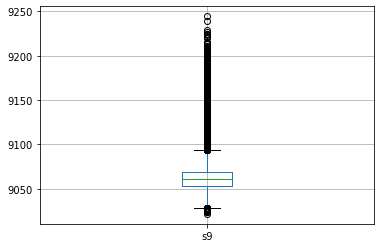

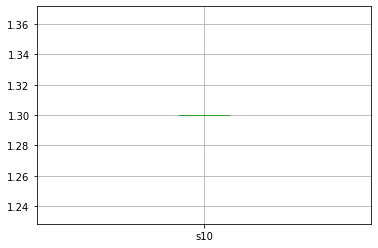

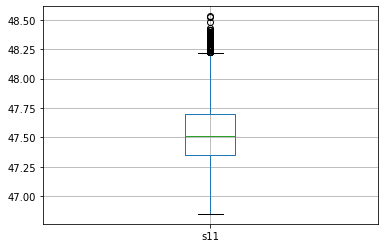

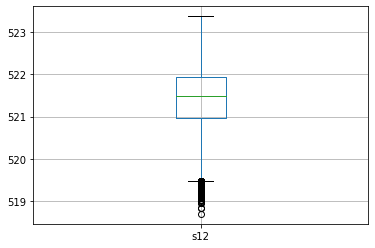

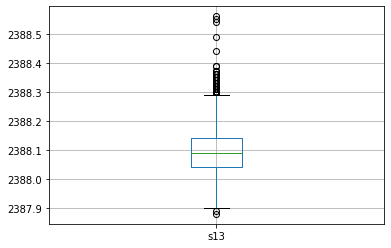

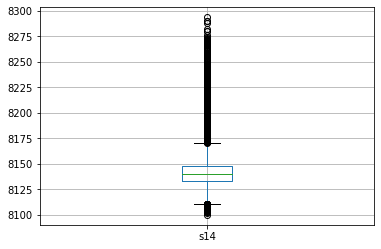

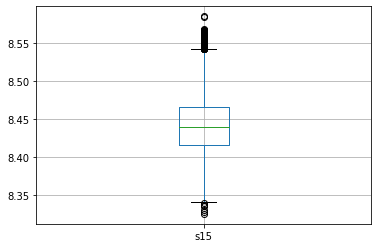

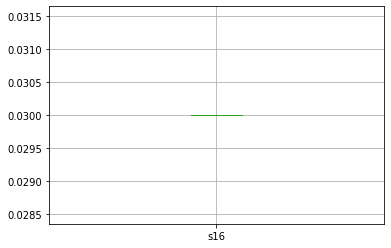

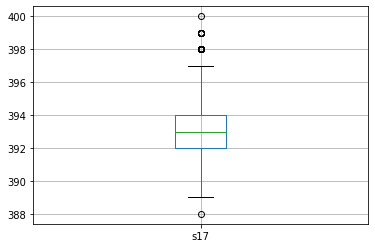

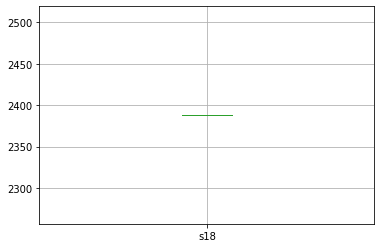

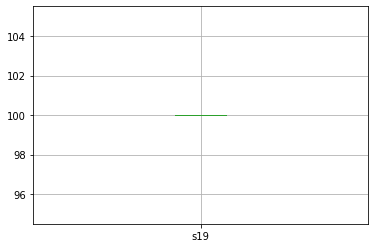

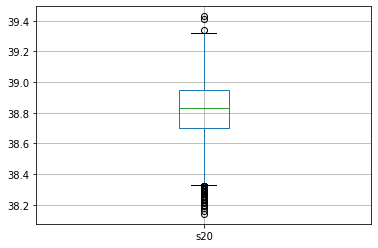

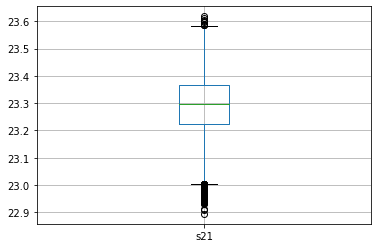

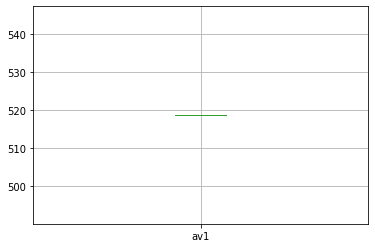

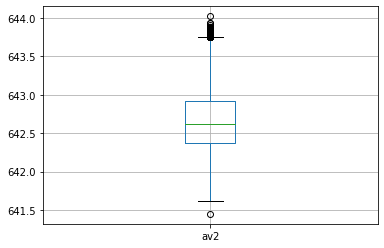

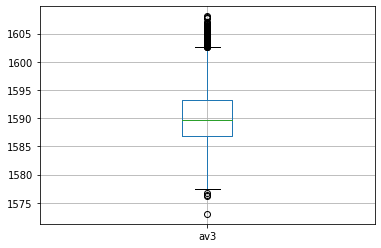

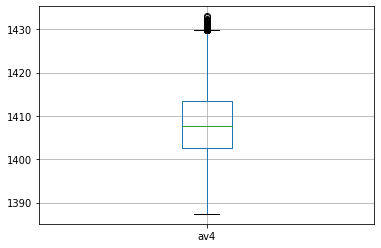

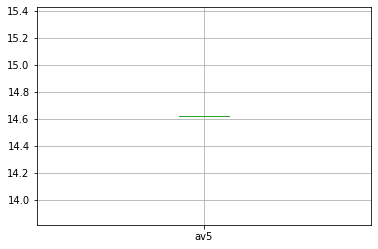

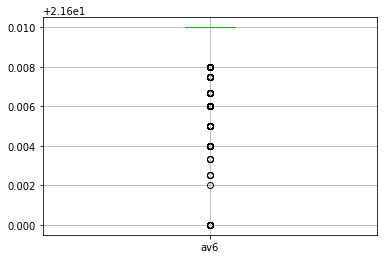

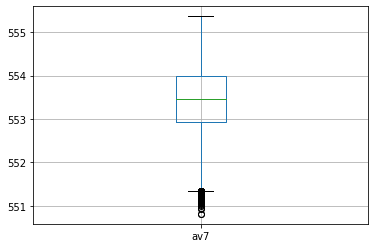

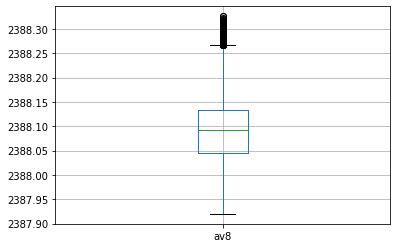

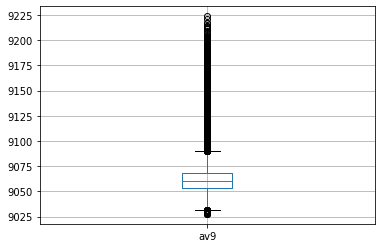

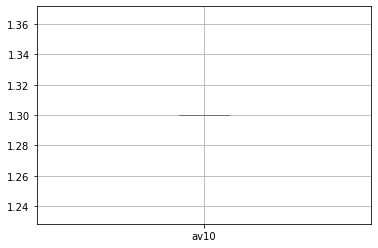

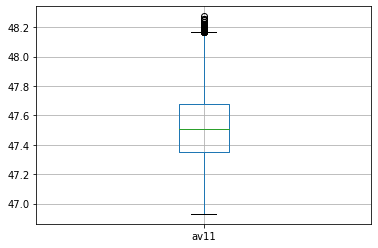

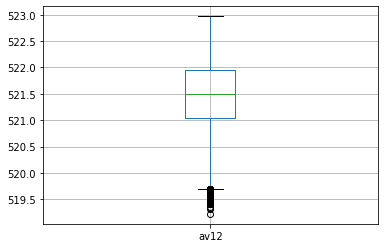

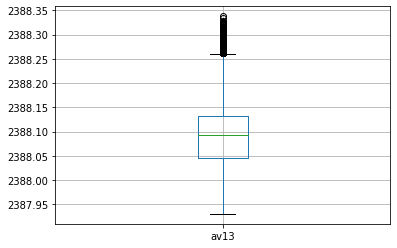

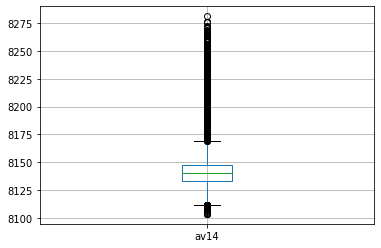

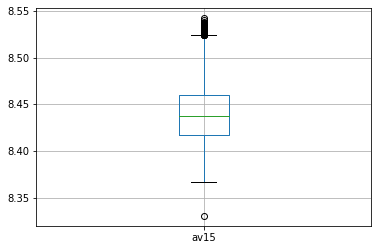

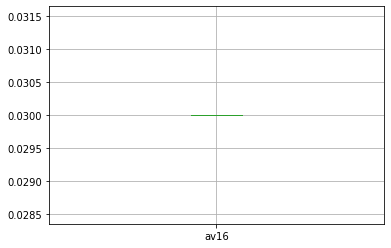

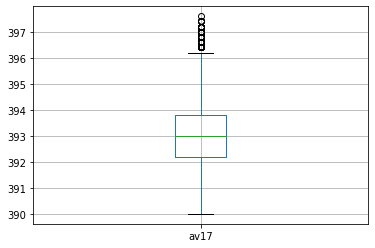

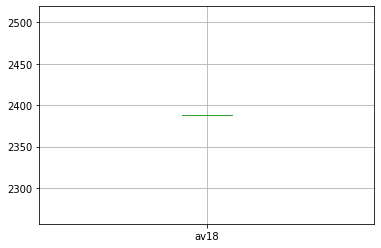

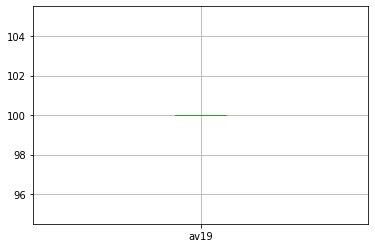

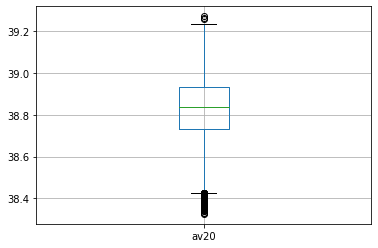

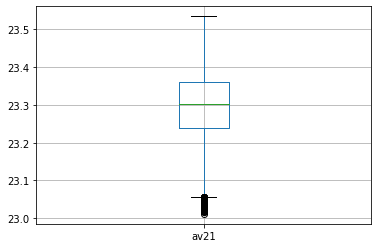

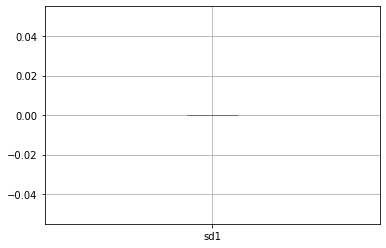

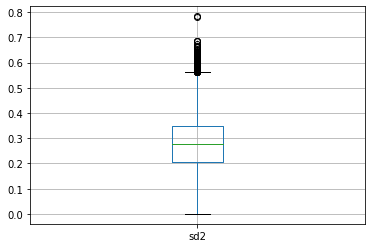

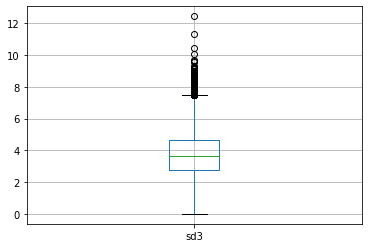

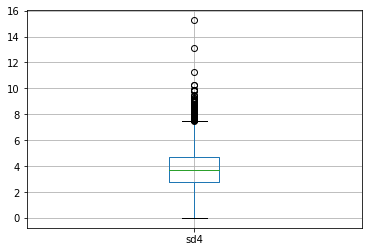

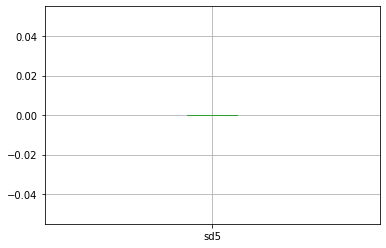

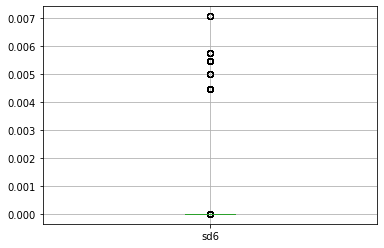

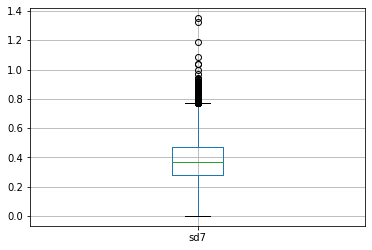

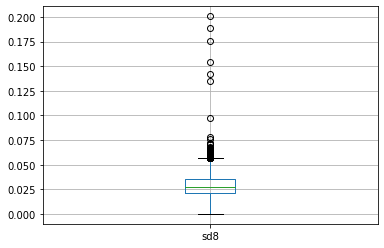

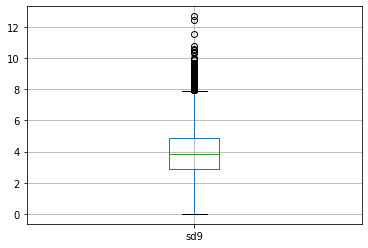

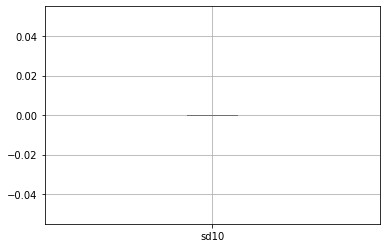

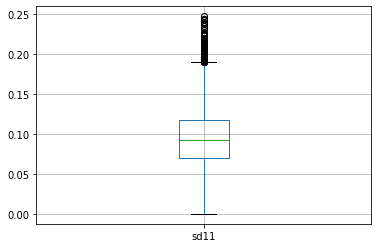

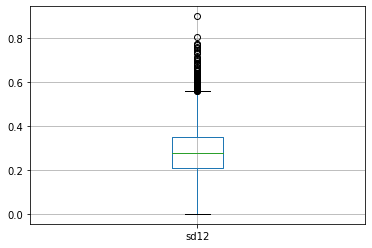

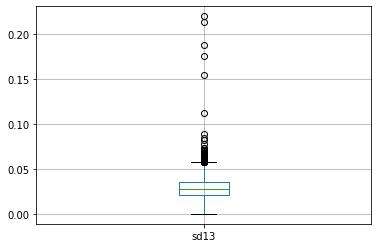

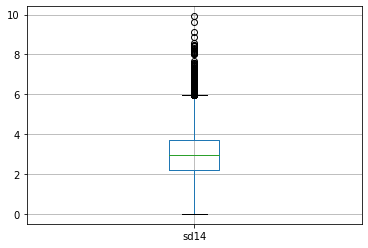

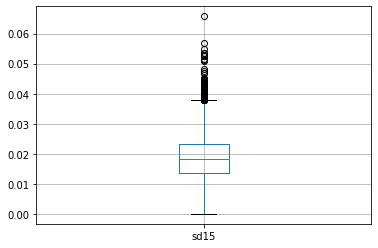

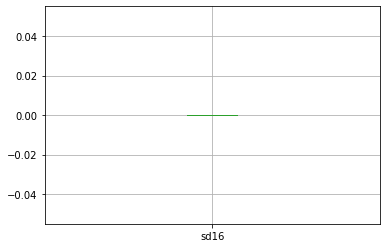

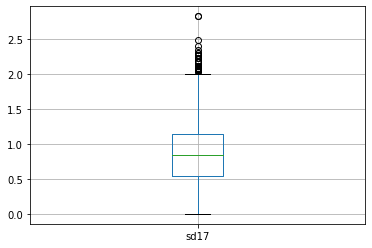

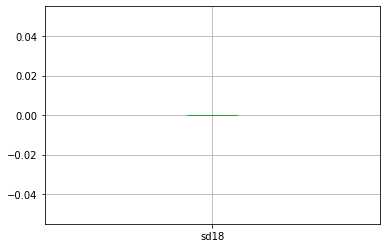

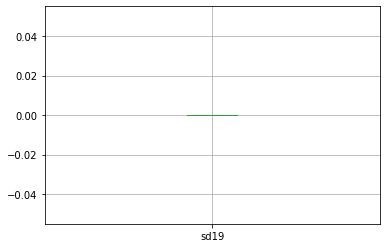

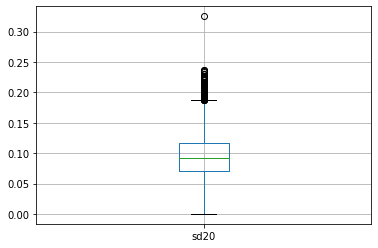

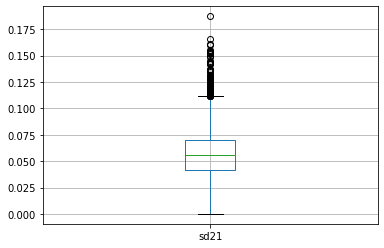

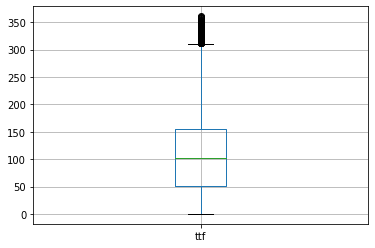

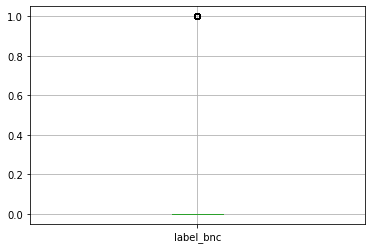

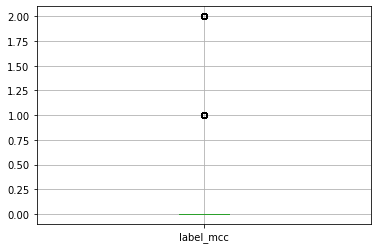

In [70]:
import matplotlib.pyplot as plt
for column in df_train:
    plt.figure()
    df_train.boxplot([column])    

In [12]:
df_train['label_mcc'].value_counts()

0    17531
2     1600
1     1500
Name: label_mcc, dtype: int64

In [13]:
print(df_train['label_bnc'].value_counts())
print('\n*** while positive mean broken engine ***')
print('\nNegaitve samples =  {0:.0%}'.format(df_train['label_bnc'].value_counts()[0]/df_train['label_bnc'].count()))
print('\nPosiitve samples =  {0:.0%}'.format(df_train['label_bnc'].value_counts()[1]/df_train['label_bnc'].count()))

0    17531
1     3100
Name: label_bnc, dtype: int64

*** while positive mean broken engine ***

Negaitve samples =  85%

Posiitve samples =  15%


In [14]:
count_class_0, count_class_1 = df_train.label_bnc.value_counts()

In [15]:
df_class_0 = df_train[df_train['label_bnc'] == 0]
df_class_1 = df_train[df_train['label_bnc'] == 1]

Random under-sampling:
1    3100
0    3100
Name: label_bnc, dtype: int64


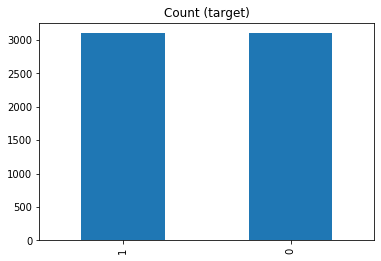

In [16]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
print('Random under-sampling:')
print(df_test_under.label_bnc.value_counts())
df_test_under.label_bnc.value_counts().plot(kind='bar', title='Count (target)');

In [17]:
df_train = pd.concat([df_class_0_under,df_class_1])

In [18]:
df_train['label_bnc'].value_counts()

1    3100
0    3100
Name: label_bnc, dtype: int64

## Outliers handle

In [19]:
df_train.shape

(6200, 70)

C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

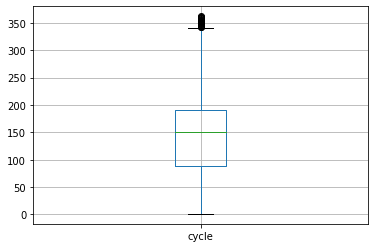

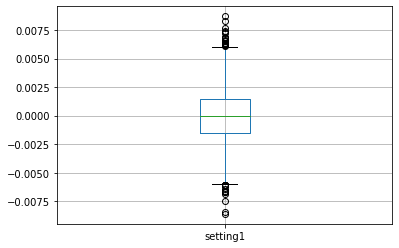

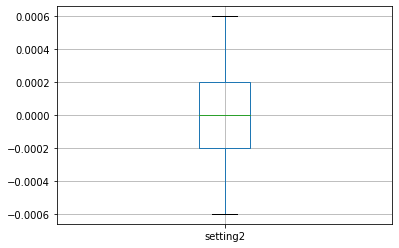

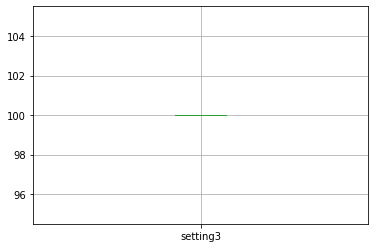

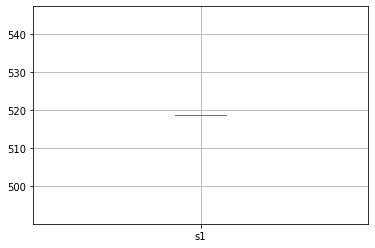

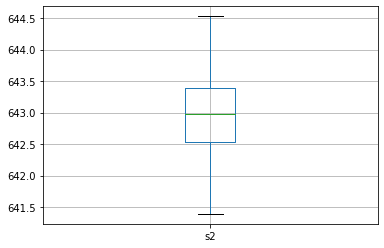

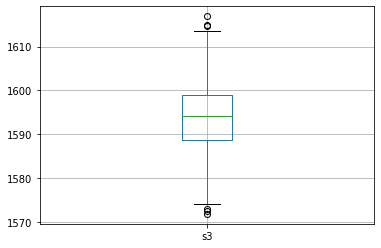

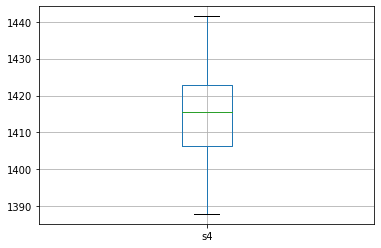

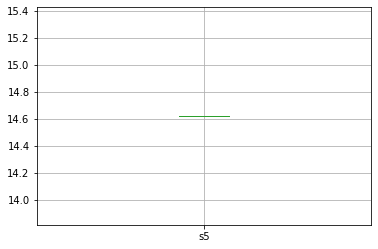

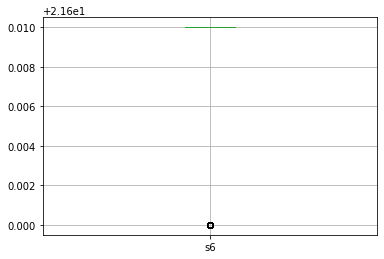

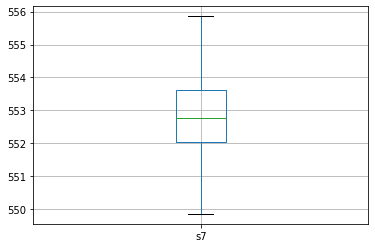

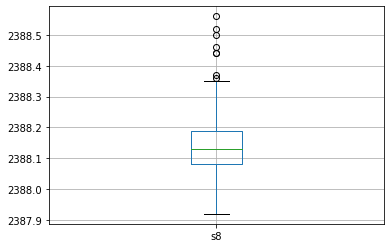

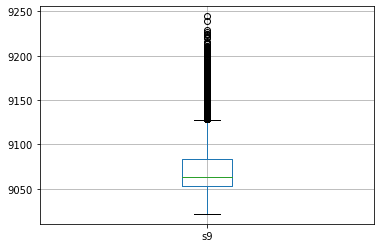

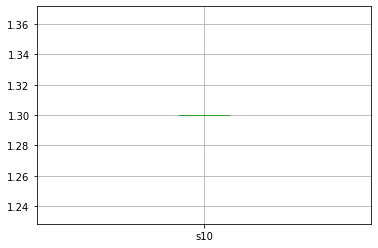

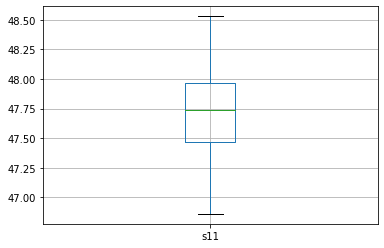

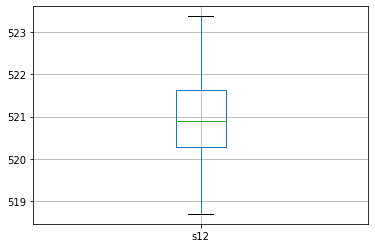

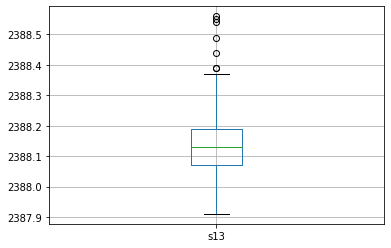

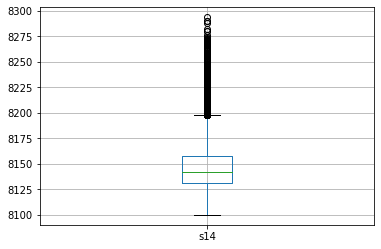

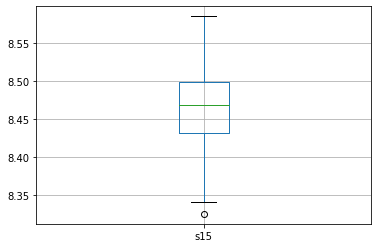

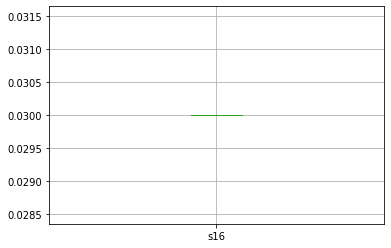

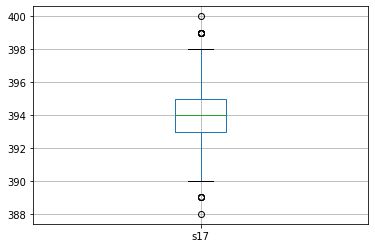

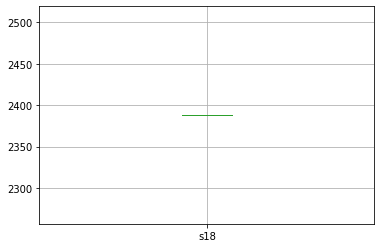

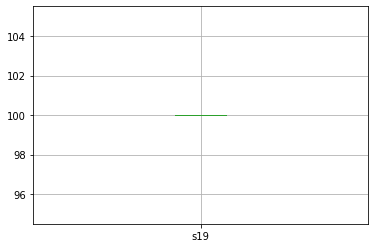

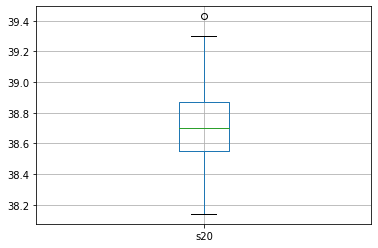

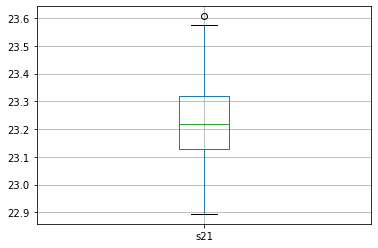

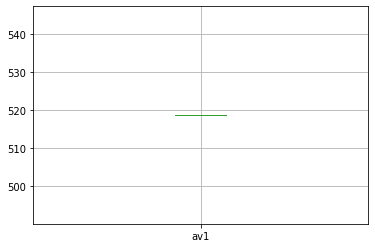

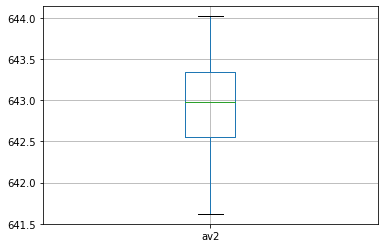

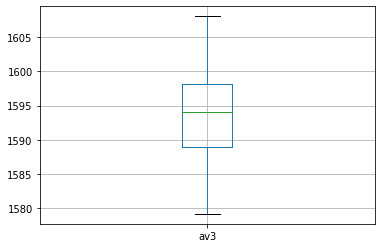

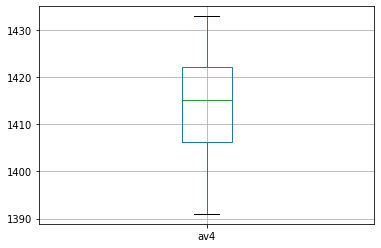

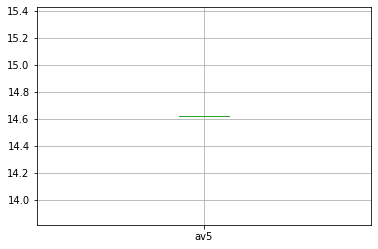

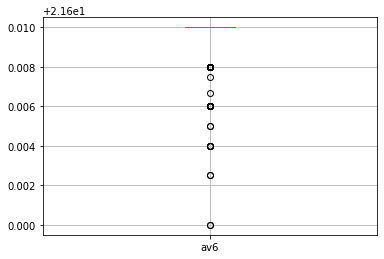

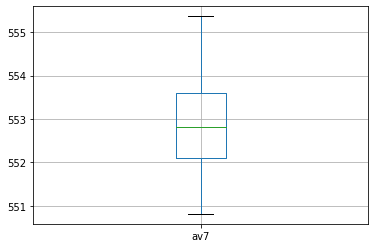

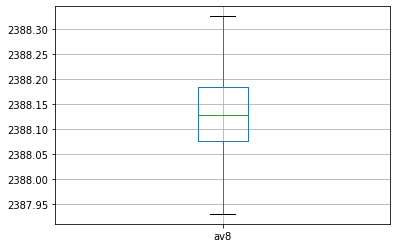

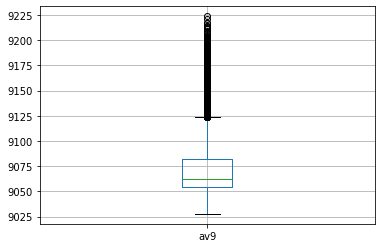

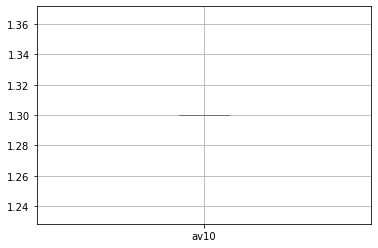

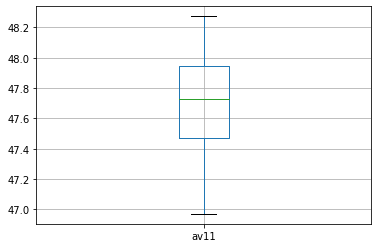

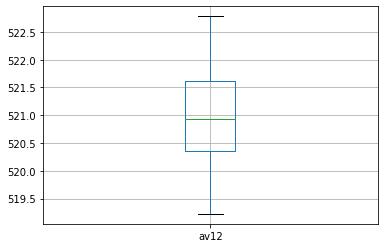

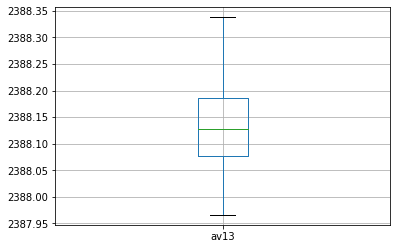

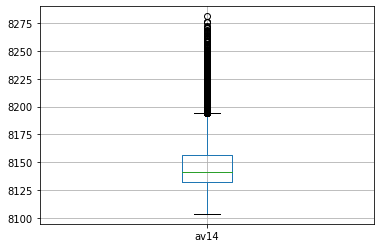

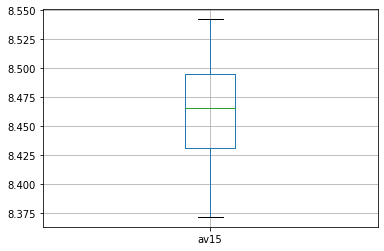

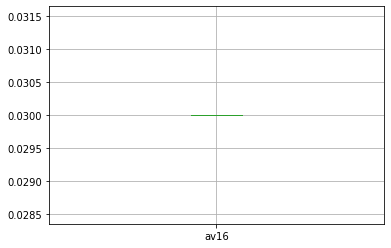

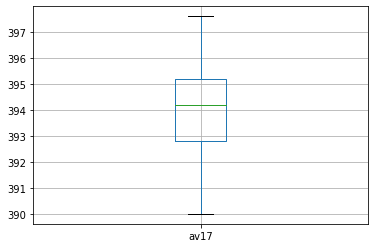

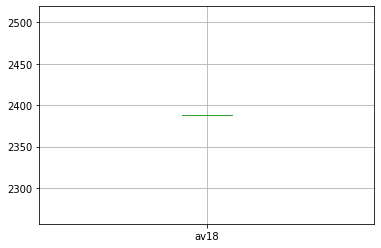

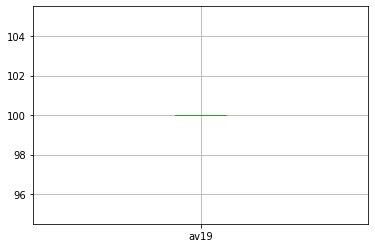

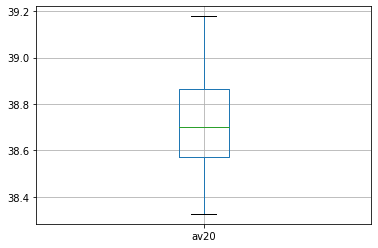

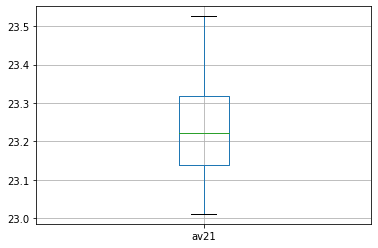

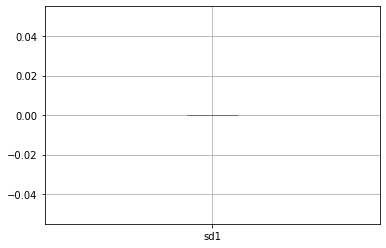

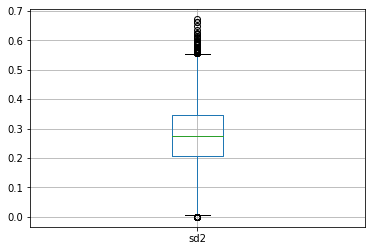

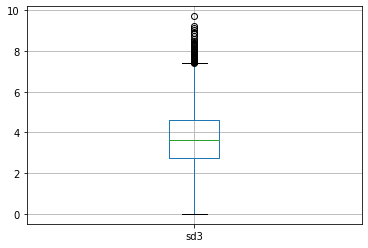

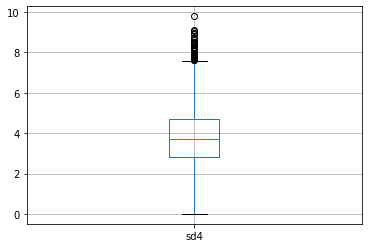

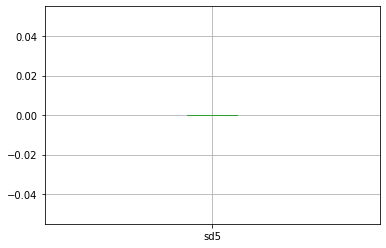

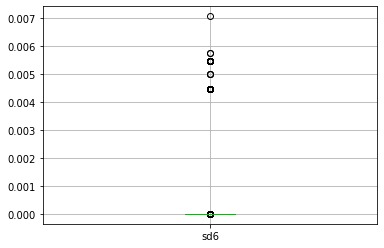

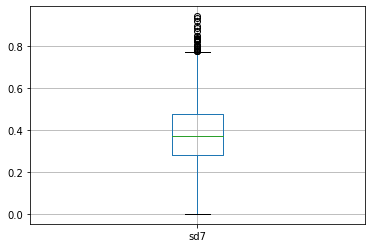

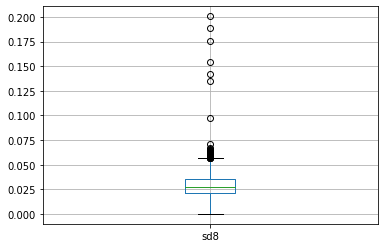

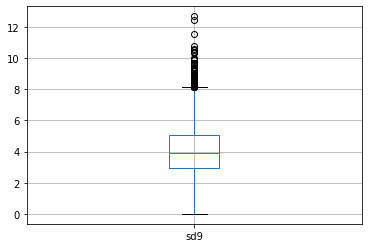

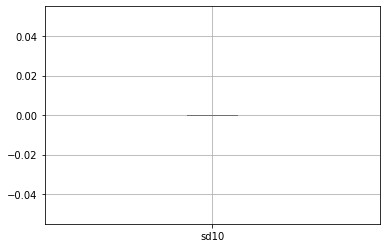

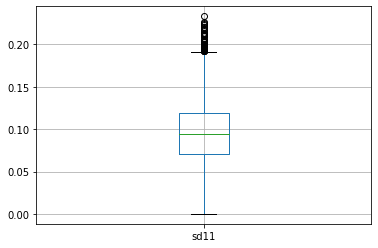

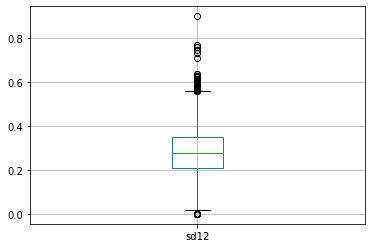

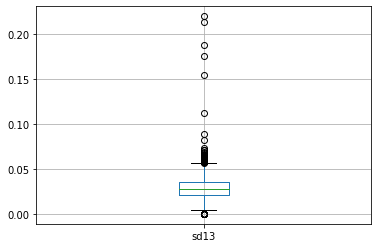

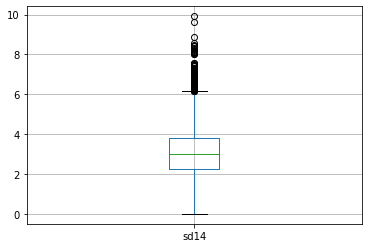

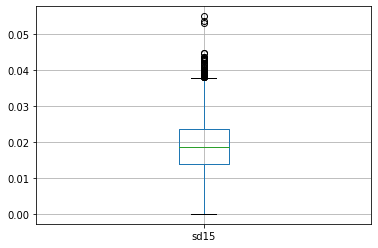

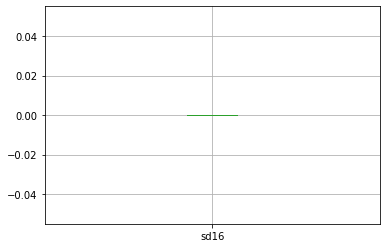

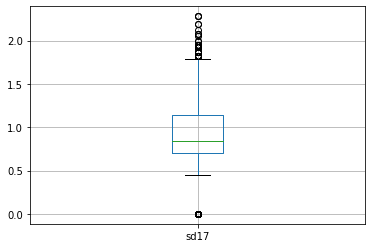

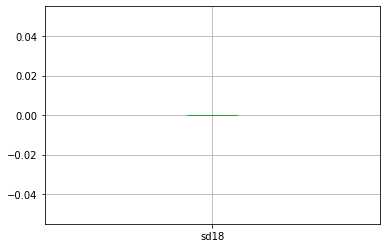

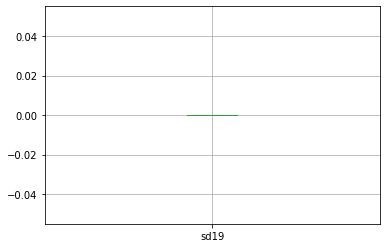

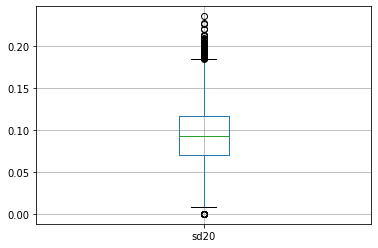

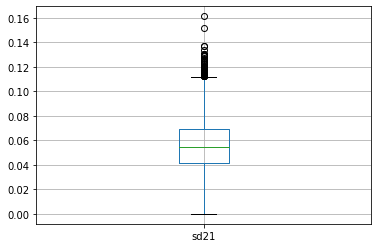

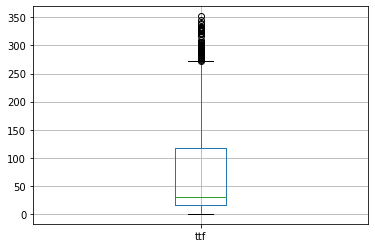

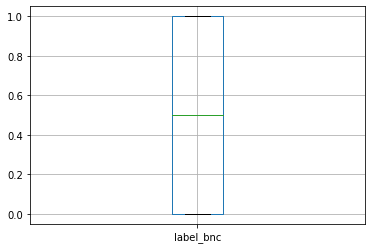

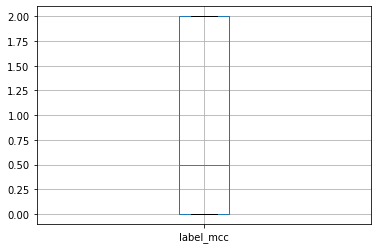

In [49]:
import matplotlib.pyplot as plt
for column in df_train:
    plt.figure()
    df_train.boxplot([column])    

In [20]:
Q1 = df_train.quantile(0.05)
Q3 = df_train.quantile(0.95)
IQR = Q3 - Q1                         

In [21]:
df_train = df_train[~((df_train < (Q1 - 1.5 * IQR)) |(df_train > (Q3 + 1.5 * IQR))).any(axis=1)]
df_train.shape

(5894, 70)

C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\peravit2\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the py

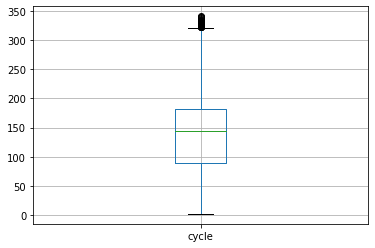

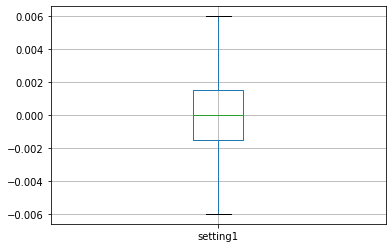

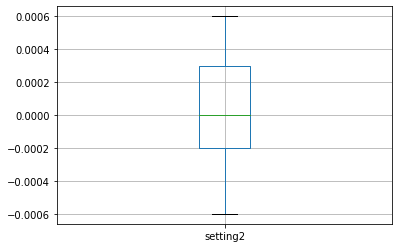

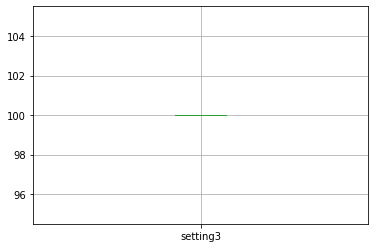

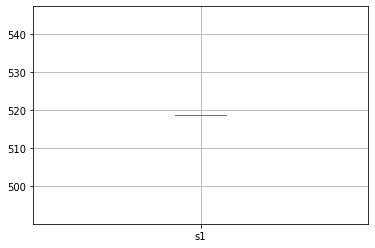

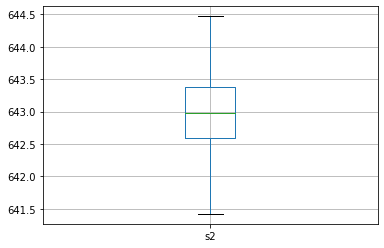

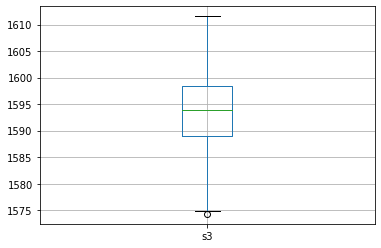

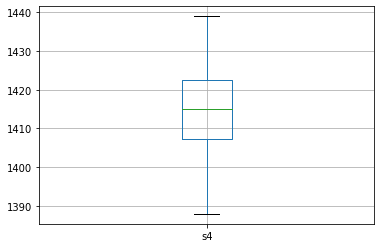

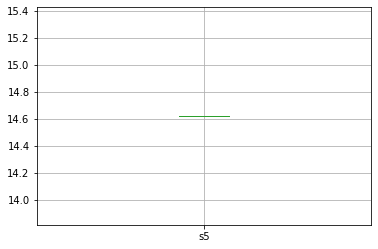

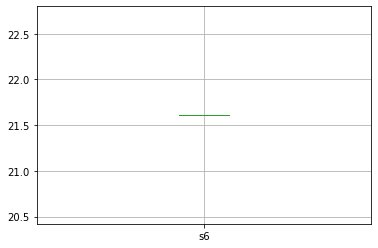

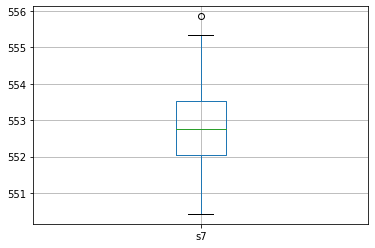

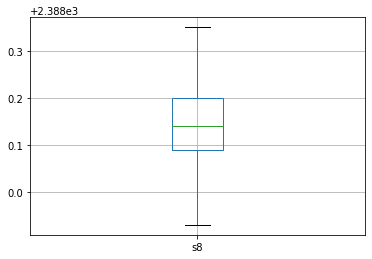

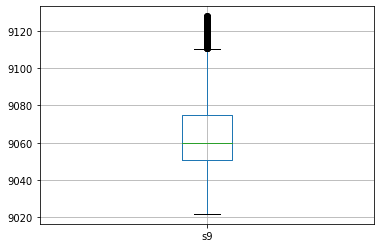

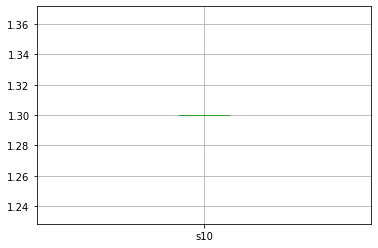

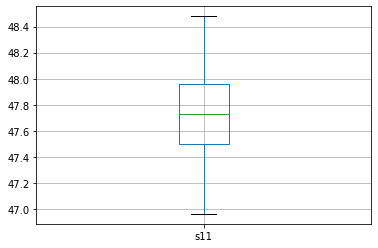

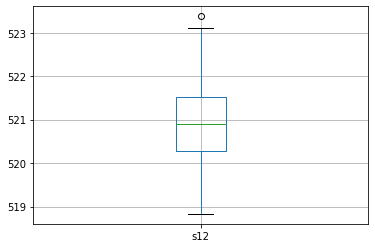

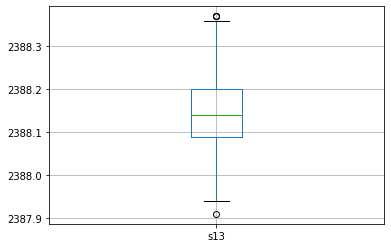

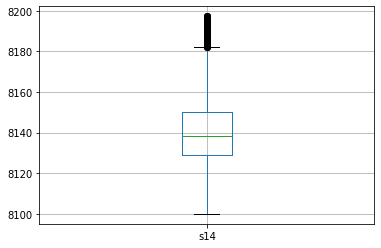

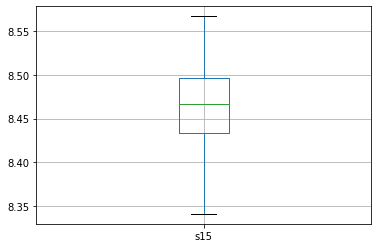

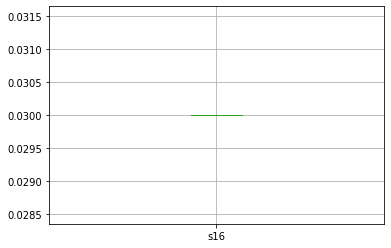

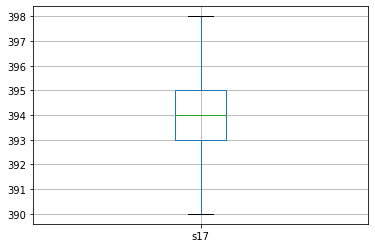

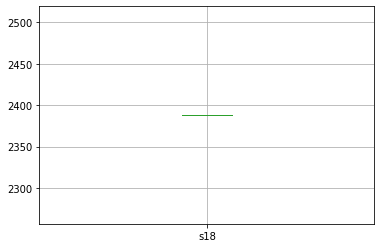

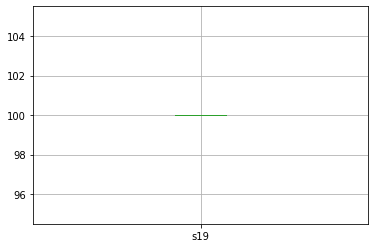

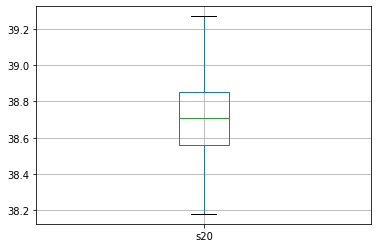

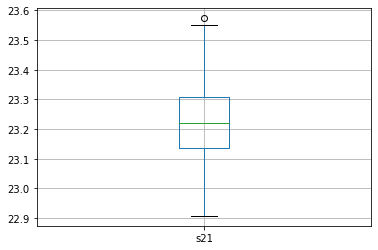

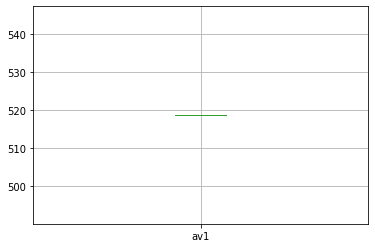

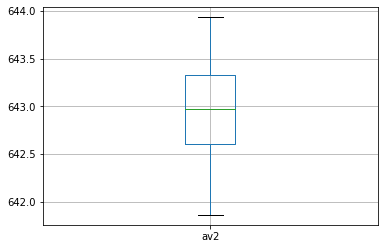

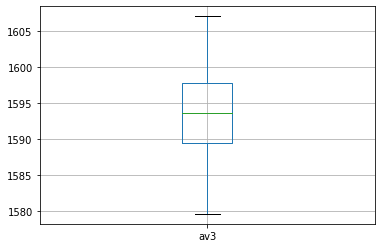

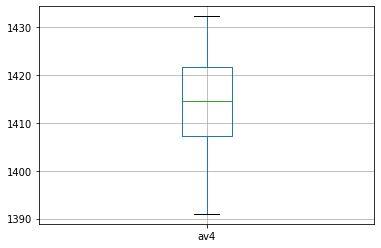

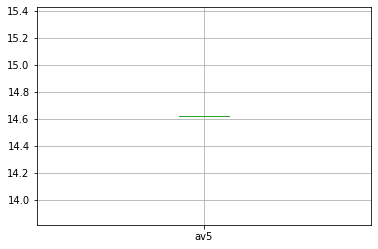

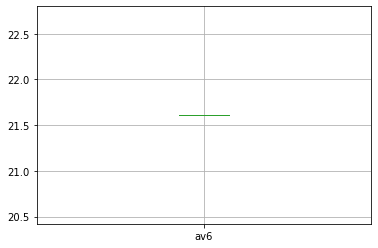

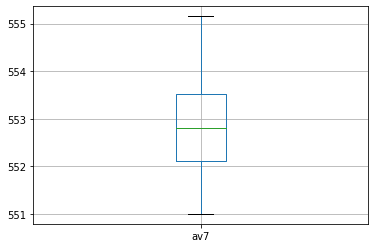

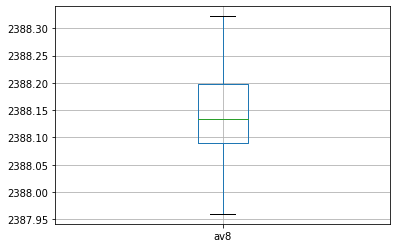

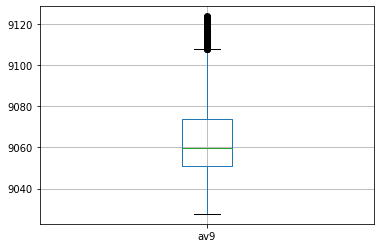

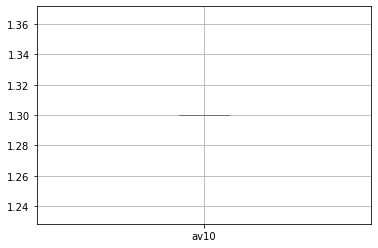

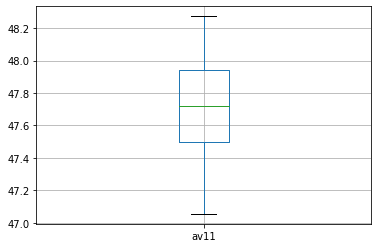

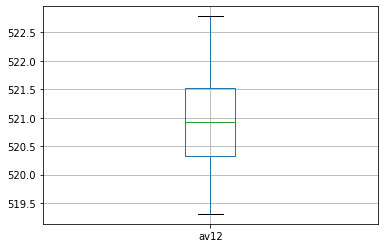

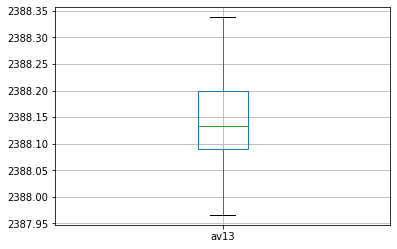

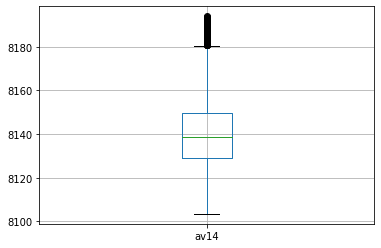

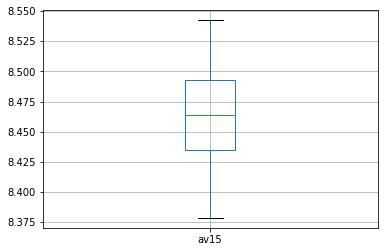

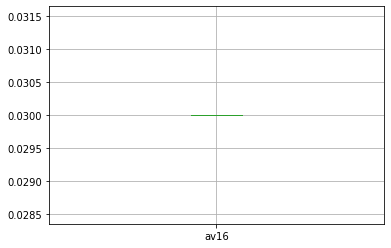

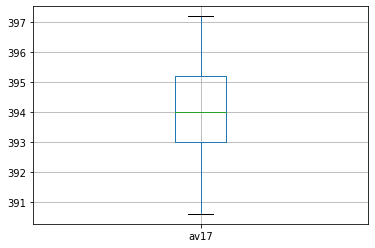

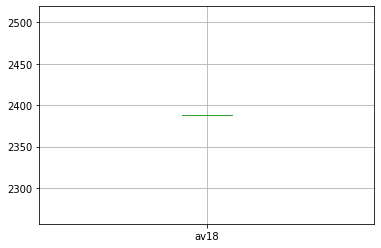

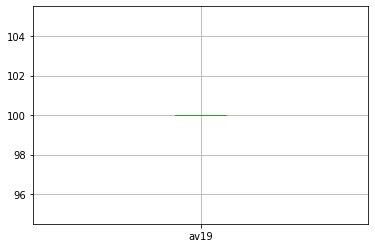

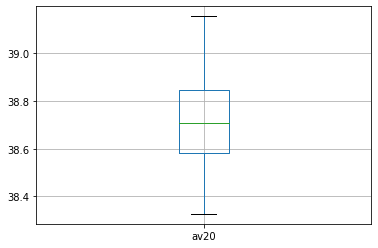

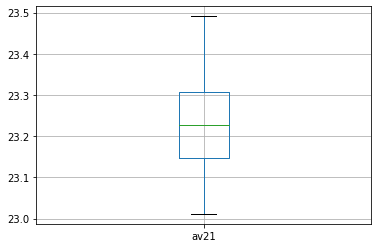

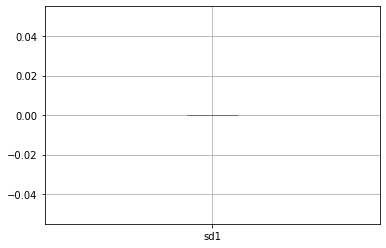

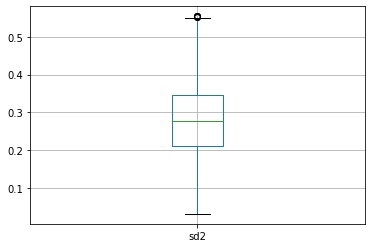

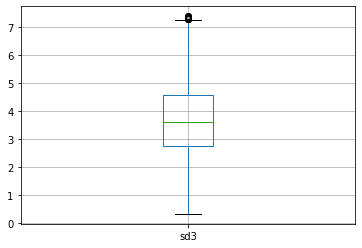

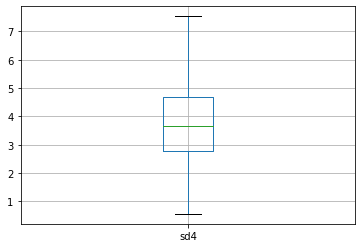

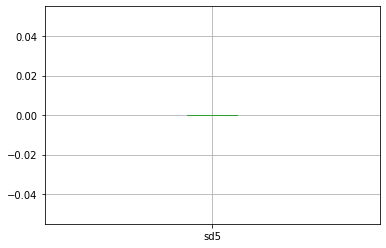

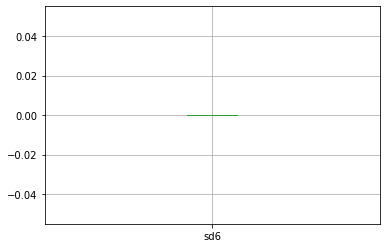

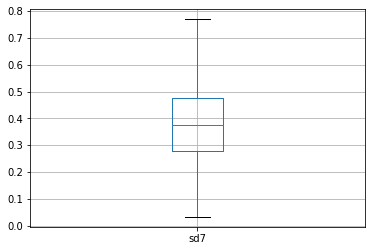

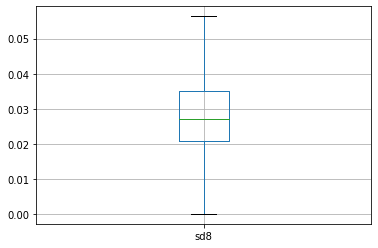

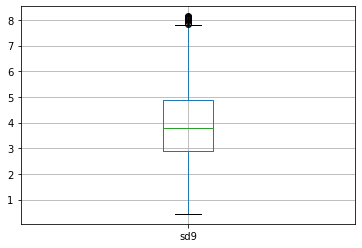

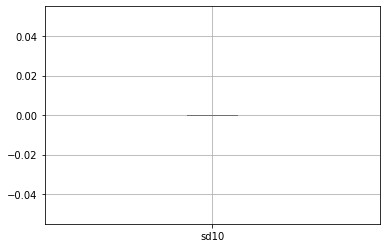

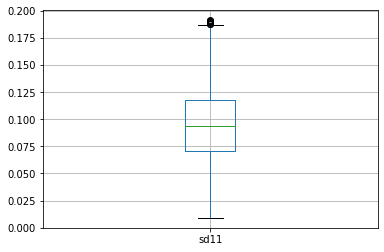

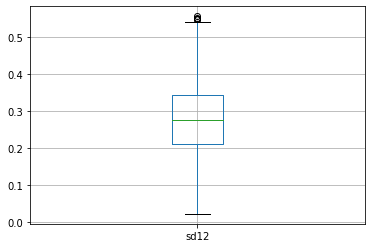

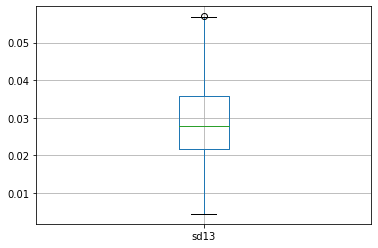

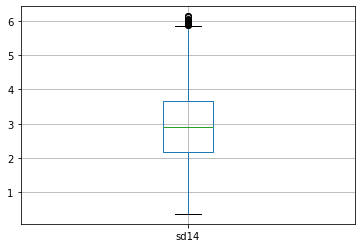

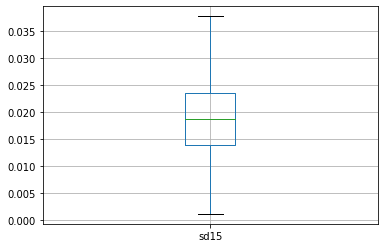

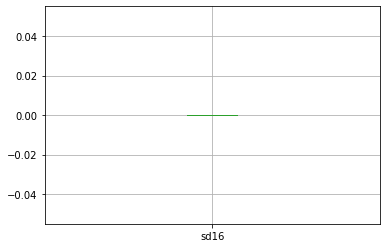

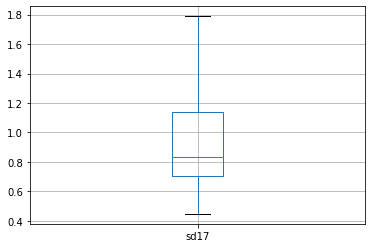

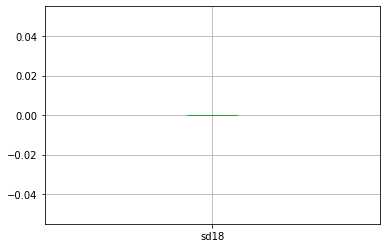

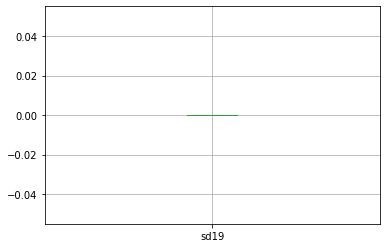

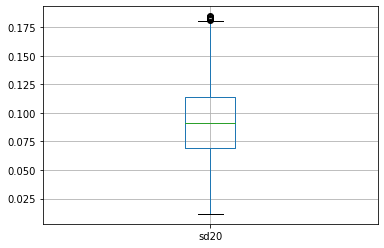

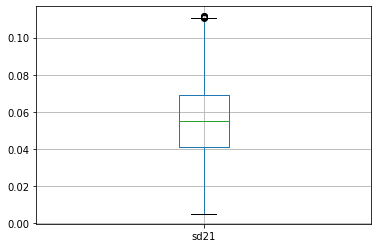

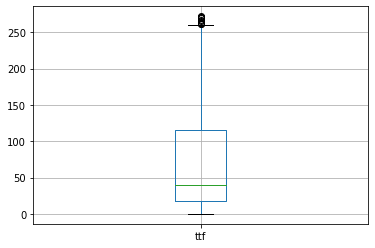

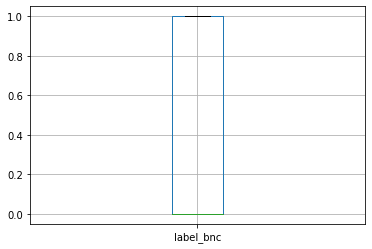

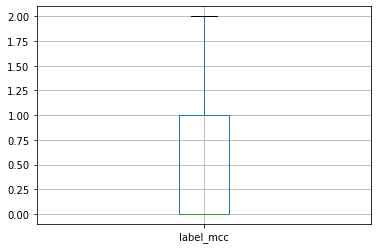

In [52]:
import matplotlib.pyplot as plt
for column in df_train:
    plt.figure()
    df_train.boxplot([column])    

In [80]:
y_train = df_train['label_bnc']
y_test = df_test['label_bnc']

In [81]:
X_train = df_train.iloc[:,1:67]
X_test = df_test.iloc[:,1:67]  ##d leaw

In [82]:
df_train['label_bnc'].value_counts()

1    3094
0    2827
Name: label_bnc, dtype: int64

In [83]:
X_train.head(2)

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,sd12,sd13,sd14,sd15,sd16,sd17,sd18,sd19,sd20,sd21
12223,-0.0012,0.0004,100.0,518.67,642.67,1595.83,1418.07,14.62,21.61,552.97,...,0.266777,0.015811,2.225639,0.024209,0.0,0.83666,0.0,0.0,0.173868,0.043243
18096,0.0038,-0.0002,100.0,518.67,642.39,1583.06,1402.09,14.62,21.61,553.78,...,0.361179,0.019235,3.647961,0.009535,0.0,1.30384,0.0,0.0,0.111131,0.037360


In [84]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [85]:
X_train.shape

(5921, 66)

# Analytics

In [329]:
df_train.columns

Index(['cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4',
       's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15',
       's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4',
       'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13',
       'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1',
       'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11',
       'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20',
       'sd21', 'ttf', 'label_bnc', 'label_mcc'],
      dtype='object')

In [330]:
features = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

In [331]:
features = ['av21', 'av20', 'av12', 'av7', 's12', 's7', 's21', 's15', 's4', 's11', 'av2', 'av3', 'av17', 'av15', 'av4', 'av11']

In [332]:
def bin_classify(model, clf, features, params=None, score=None):

    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    return grid_search.best_estimator_, df_predictions

In [333]:
def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model]  

    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)
    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP']) 
    df_roc_thresh['Model'] = model
    
    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)
    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)
        print('\nROC Thresholds:\n')
        print(df_roc_thresh[[ 'TP', 'FP', 'TN', 'FN']])
    return  df_metrics, df_roc_thresh

In [334]:
model = 'Logistic Regression'
clf_lgra = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_lgra, pred_lgra = bin_classify(model, clf_lgra, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgr, roc_lgr = bin_class_metrics(model, y_test, pred_lgra.y_pred, pred_lgra.y_score, print_out=True, plot_out=True)


Best Parameters:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------------------------------
Logistic Regression 

Confusion Matrix:
[[71  4]
 [ 3 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        75
           1       0.85      0.88      0.86        25

    accuracy                           0.93       100
   macro avg       0.90      0.91      0.91       100
weighted avg       0.93      0.93      0.93       100


Metrics:
           Logistic Regression
Accuracy              0.930000
Precision             0.846154
Recall                0.880000
F1 Score              0.862745
ROC AUC              

In [30]:
model = 'Logistic Regression'
clf_lgra = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_lgra, pred_lgra = bin_classify(model, clf_lgra, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgr, roc_lgr = bin_class_metrics(model, y_test, pred_lgra.y_pred, pred_lgra.y_score, print_out=True, plot_out=True)


Best Parameters:
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------------------------------
Logistic Regression 

Confusion Matrix:
[[71  4]
 [ 3 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        75
           1       0.85      0.88      0.86        25

    accuracy                           0.93       100
   macro avg       0.90      0.91      0.91       100
weighted avg       0.93      0.93      0.93       100


Metrics:
           Logistic Regression
Accuracy              0.930000
Precision             0.846154
Recall                0.880000
F1 Score              0.862745
ROC AUC              

In [31]:
model = 'Decision Tree'
clf_dtra = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [3, 4, 5, 6, 7], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtra, pred_dtra = bin_classify(model, clf_dtra, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_dtra)

metrics_dtr, roc_dtr = bin_class_metrics(model, y_test, pred_dtra.y_pred, pred_dtra.y_score, print_out=True, plot_out=True)



Best Parameters:
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')
-----------------------------------------------------------
Decision Tree 

Confusion Matrix:
[[73  2]
 [ 7 18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        75
           1       0.90      0.72      0.80        25

    accuracy                           0.91       100
   macro avg       0.91      0.85      0.87       100
weighted avg       0.91      0.91      0.91       100


Metrics:
           Decision Tree
Accuracy        0.910000
Precision       0.900000
Recall          0.720000
F1 

In [32]:
model = 'Random Forest'
clf_rfca = RandomForestClassifier(n_estimators=400, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_rfca, pred_rfca = bin_classify(model, clf_rfca, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfca)

metrics_rfc, roc_rfc = bin_class_metrics(model, y_test, pred_rfca.y_pred, pred_rfca.y_score, print_out=True, plot_out=True)


Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest 

Confusion Matrix:
[[71  4]
 [ 3 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        75
           1       0.85      0.88      0.86        25

    accuracy                           0.93       100
   macro avg       0.90      0.91      0.91       100
weighted avg       0.93      0.93      0.93       100


Metrics:
           Random

In [33]:
model = 'SVC'
clf_svca = SVC(kernel='rbf', random_state=123)
gs_params = {'C': [1.0]}
gs_score = 'roc_auc'

clf_svca, pred_svca = bin_classify(model, clf_svca, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svca)

metrics_svc, roc_svc = bin_class_metrics(model, y_test, pred_svca.y_pred, pred_svca.y_score, print_out=True, plot_out=True)

C:\Users\peravit2\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Best Parameters:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=123,
    shrinking=True, tol=0.001, verbose=False)
-----------------------------------------------------------
SVC 

Confusion Matrix:
[[64 11]
 [ 4 21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.90        75
           1       0.66      0.84      0.74        25

    accuracy                           0.85       100
   macro avg       0.80      0.85      0.82       100
weighted avg       0.87      0.85      0.86       100


Metrics:
                SVC
Accuracy   0.850000
Precision  0.656250
Recall     0.840000
F1 Score   0.736842
ROC AUC    0.968000

ROC Thresholds:

    TP  FP  TN  FN
0    0  25  75   0
1    1  24  75   0
2   18   7  75   0
3   18   7  73   2
4   20   5  73   2
5   20   5  72   3
6   2

In [34]:
model = 'KNN'
clf_knnb = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [5, 10, 20, 25, 30]}
gs_score = 'roc_auc'
clf_knnb, pred_knnb = bin_classify(model, clf_knnb, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_knnb)
metrics_knn, roc_knn = bin_class_metrics(model, y_test, pred_knnb.y_pred, pred_knnb.y_score, print_out=True, plot_out=True)


Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
                     weights='uniform')
-----------------------------------------------------------
KNN 

Confusion Matrix:
[[66  9]
 [ 4 21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        75
           1       0.70      0.84      0.76        25

    accuracy                           0.87       100
   macro avg       0.82      0.86      0.84       100
weighted avg       0.88      0.87      0.87       100


Metrics:
                KNN
Accuracy   0.870000
Precision  0.700000
Recall     0.840000
F1 Score   0.763636
ROC AUC    0.974667

ROC Thresholds:

    TP  FP  TN  FN
0    0  25  75   0
1   11  14  75   0
2   13  12  75   0
3   15  10  74   1
4   17   8  74   1
5   18   7  73   2
6   19   6  73   2
7   21   4  72   3
8   21   4  71   4
9  

In [35]:
model = 'Gaussian NB'
clf_gnbb = GaussianNB()
gs_params = {} 
gs_score = 'roc_auc'

clf_gnbb, pred_gnbb = bin_classify(model, clf_gnbb, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_gnbb)

metrics_gnb, roc_gnb = bin_class_metrics(model, y_test, pred_gnbb.y_pred, pred_gnbb.y_score, print_out=True, plot_out=True)


Best Parameters:
 GaussianNB(priors=None, var_smoothing=1e-09)
-----------------------------------------------------------
Gaussian NB 

Confusion Matrix:
[[65 10]
 [ 2 23]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92        75
           1       0.70      0.92      0.79        25

    accuracy                           0.88       100
   macro avg       0.83      0.89      0.85       100
weighted avg       0.90      0.88      0.88       100


Metrics:
           Gaussian NB
Accuracy      0.880000
Precision     0.696970
Recall        0.920000
F1 Score      0.793103
ROC AUC       0.927733

ROC Thresholds:

   TP  FP  TN  FN
0   0  25  75   0
1  17   8  68   7
2  20   5  68   7
3  20   5  65  10
4  24   1  65  10
5  24   1  60  15
6  25   0  60  15
7  25   0   0  75


In [60]:
model = 'Gradient Boosting'

clf_gbc = GradientBoostingClassifier(random_state=123)
gs_params = {'max_depth':[3,4,5,6,7], 'min_samples_split':[2], 'min_samples_leaf':[1], 'subsample':[1],'max_features':['sqrt'],'n_estimators':[250]}
gs_score = 'roc_auc'

clf_gbc, pred_gbc = bin_classify(model, clf_gbc, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_gbc)

metrics_gbc, roc_gbc = bin_class_metrics(model, y_test, pred_gbc.y_pred, pred_gbc.y_score, print_out=True, plot_out=True)


Best Parameters:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='auto',
                           random_state=123, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
-----------------------------------------------------------
Gradient Boosting 

Confusion Matrix:
[[70  5]
 [ 1 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96        75
           1       0.83      0.96      0.89        25

 

In [65]:
model = 'XGBoost'

clf_xgb = xgb.XGBClassifier(random_state=123)
gs_params = {'max_depth':[3,4,5], 'n_estimators':[6], 'learning_rate':[0.1], 'subsample':[0.8],'max_features':['sqrt'],'colsample_bytree': [0.5]}
gs_score = 'roc_auc'

clf_xgb, pred_xgb = bin_classify(model, clf_xgb, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_xgb)

metrics_xgb, roc_xgb = bin_class_metrics(model, y_test, pred_xgb.y_pred, pred_xgb.y_score, print_out=True, plot_out=True)
 


Best Parameters:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              max_features='sqrt', min_child_weight=1, missing=None,
              n_estimators=6, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.8, verbosity=1)
-----------------------------------------------------------
XGBoost 

Confusion Matrix:
[[70  5]
 [ 2 23]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        75
           1       0.82      0.92      0.87        25

    accuracy                           0.93       100
   macro avg       0.90      0.93      0.91       100
weighted avg       0.93      0.93      0.93       100


Metrics:
    

In [66]:
model = 'SGD'

clf_sgd = SGDClassifier(random_state=123)
gs_params = {'loss': [ 'hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']}
gs_score = 'roc_auc'

clf_sgd, pred_sgd = bin_classify(model, clf_sgd, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_sgd)

metrics_sgd, roc_sgd = bin_class_metrics(model, y_test, pred_sgd.y_pred, pred_sgd.y_score, print_out=True, plot_out=True)
 


Best Parameters:
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
-----------------------------------------------------------
SGD 

Confusion Matrix:
[[72  3]
 [ 3 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        75
           1       0.88      0.88      0.88        25

    accuracy                           0.94       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.94      0.94      0.94       100


Metrics:
                SGD
Accuracy   0.940000
Precision  0.880000
Recall     0.880000
F1 Score   0.880

In [67]:
model = 'AdaBoost_RF'
DTC = DecisionTreeClassifier(random_state = 123, max_features = "auto", class_weight = "balanced",max_depth = None)
clf_ada = AdaBoostClassifier(base_estimator = DTC)
gs_params = {"base_estimator__criterion" : ["gini", "entropy"],"base_estimator__splitter" :   ["best", "random"],"n_estimators": [8000,8000], }
gs_score = 'roc_auc'

clf_ada, pred_ada = bin_classify(model, clf_ada, features, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_ada)

metrics_ada, roc_ada = bin_class_metrics(model, y_test, pred_ada.y_pred, pred_ada.y_score, print_out=True, plot_out=True)


Best Parameters:
 AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=12

# compare all models

In [68]:
metrics_bn = pd.concat([metrics_lgr, metrics_dtr, metrics_rfc, metrics_svc, metrics_knn, metrics_gnb,metrics_xgb,metrics_gbc,metrics_sgd,metrics_ada], axis=1)
metrics_bn

,Logistic Regression,Decision Tree,Random Forest,SVC,KNN,Gaussian NB,XGBoost,Gradient Boosting,SGD,AdaBoost_RF
Accuracy,0.930000,0.910000,0.930000,0.850000,0.870000,0.880000,0.930000,0.940000,0.940000,0.880000
Precision,0.846154,0.900000,0.846154,0.656250,0.700000,0.696970,0.821429,0.827586,0.880000,0.740741
Recall,0.880000,0.720000,0.880000,0.840000,0.840000,0.920000,0.920000,0.960000,0.880000,0.800000
F1 Score,0.862745,0.800000,0.862745,0.736842,0.763636,0.793103,0.867925,0.888889,0.880000,0.769231
ROC AUC,0.983467,0.950933,0.982933,0.968000,0.974667,0.927733,0.982933,0.982933,0.988267,0.853333


In [69]:
metrics_bn= metrics_bn.transpose()

In [70]:
i=[]
for col in metrics_bn.columns: 
    i.append(col)
i

['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

In [94]:
## maximize recall  **first priority  , minimize precision
df_max_profit = metrics_bn[i].sort_values(by=[ 'Recall' ,'Precision','Accuracy'],
                                    ascending=[False,False,False]).reset_index(drop=False)
df_max_profit.columns=['Model','Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
df_max_profit

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Gradient Boosting,0.94,0.827586,0.96,0.888889,0.982933
1,XGBoost,0.93,0.821429,0.92,0.867925,0.982933
2,Gaussian NB,0.88,0.696970,0.92,0.793103,0.927733
3,SGD,0.94,0.880000,0.88,0.880000,0.988267
4,Logistic Regression,0.93,0.846154,0.88,0.862745,0.983467
5,Random Forest,0.93,0.846154,0.88,0.862745,0.982933
6,KNN,0.87,0.700000,0.84,0.763636,0.974667
7,SVC,0.85,0.656250,0.84,0.736842,0.968000
8,AdaBoost_RF,0.88,0.740741,0.80,0.769231,0.853333
9,Decision Tree,0.91,0.900000,0.72,0.800000,0.950933
